# Analyzing GP Appointment Capacity and Utilization in NHS England

## Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose

## Functions

### Data Viewing and Validation

In [2]:
# Data viewing function
def view_data(df):
    """
    Prints the shape, head, and data types for a DataFrame

    Args:
        (df): DataFrame name

    Returns:
        shape, head, and data types of DataFrame
    """
    #shape
    print("DataFrame shape:", df.shape)

    #head
    print("DataFrame head:")
    print(df.head)

    #data types
    print("DataFrame data types:")
    print(df.dtypes)

In [8]:
# Data validation function
def validate_data(df):
    """
    Validates the data in a DataFrame by printing counts of unique values
    for each column, the number of duplicate rows, and summary statistics

    Args:
        (df): DataFrame name

    Returns:
        unique value counts, duplicate row count, and summary statistics
    """
    #check for unique values
    unique_counts = df.nunique()
    print("Unique values per column:")
    print(unique_counts)
    
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count)
    
    #summary stats
    summary_stats = df.describe()
    print("\nSummary statistics:")
    print(summary_stats)
    
    return unique_counts, duplicate_count, summary_stats

### Twitter Keyword Search

In [6]:
def keyword_count(keyword):
    """
    Calculates the number of times a keyword appears in the tweets.

    Args:
        (keyword): the word to be counted

    Returns:
        the number of times the keyword appears
    """
    return tweets[tweets['tweet_full_text'].str.contains(keyword, case=False, na=False)].shape[0]

In [7]:
def keyword_results(keyword):
    """
    Displays the tweets where the keyword appears.
    
    Args:
        (keyword): the search term

    Returns:
        the text of the tweet in which the keyword appears    
    """
    pd.set_option('display.max_colwidth', None)
    return tweets[tweets['tweet_full_text'].str.contains(keyword, case=False, na=False)]['tweet_full_text']

### Attended Appointments Percentage Calculation

I asked the AI Chatbot Claude to prepare this function to calculate attendance percentages within groups of unique values for each relevant column in the 'ar' DataFrame.

In [9]:
def calc_attd_pct_by_cols(df, group_columns):
    """
    Calculate attendance percentages for each unique value in specified columns
    and automatically create DataFrames for each column.

    Args:
        (df): DataFrame name
        (group_columns): names of columns for attendance percentage calculations

    Returns:
        Dataframes with attendance percentanges for each unique value in specified columns
    """
    for column in group_columns:
        # Create DataFrame name based on column
        attd_name = f"attd_{column.lower().replace(' ', '_')}"
        
        # Calculate percentage
        group_totals = df.groupby(column)['count_of_appointments'].sum()
        attended = df[df['appointment_status'] == 'Attended'].groupby(column)['count_of_appointments'].sum()
        attendance_percentage = (attended / group_totals * 100).round(2)
        
        # Create result DataFrame
        result_df = pd.DataFrame({
            column: attendance_percentage.index,
            'total_appointments': group_totals.values,
            'attended_appointments': attended.values,
            'attendance_percentage': attendance_percentage.values
        })
        
        # Create the DataFrame in the global namespace
        globals()[attd_name] = result_df
        
        # Print information about the created DataFrame
        print(f"\nCreated DataFrame '{attd_name}' for column '{column}'")
        print(f"Shape: {result_df.shape}")
        print("-" * 50)
        print(result_df)
        print("\n")

## Data Import

### Provided Data

In [7]:
# Create DataFrames for provided data
ad = pd.read_csv('actual_duration.csv')
ar = pd.read_csv('appointments_regional.csv')
nc = pd.read_excel('national_categories.xlsx')
tweets = pd.read_csv('tweets.csv')

### External Data

**1. ICB Names and Codes**

This ONS dataset contains ICB names and codes that are used to merge the 'ar' dataset with external data on deprivation. Source: [Integrated Care Boards (July 2022) Names and Codes in EN](https://geoportal.statistics.gov.uk/documents/25ba241a775e4a9db8e5c721ee73d85d/about)

In [8]:
# Create DataFrame from Excel file
icb_name = pd.read_excel('ICB_JUL_2022_EN_NC.xlsx')

**2. Measure of Deprivation at GP Practice level**

This dataset prepared by the Health Equity Evidence Centre provides the Index of Multiple Deprivation (IMD) score for areas at the GP practice level. Source: [Index of Multiple Deprivation (IMD) Data](https://github.com/HealthEquityEvidenceCentre/HEEC/tree/main/data/IMD)

In [9]:
# Create DataFrame from CSV file
gp_imd = pd.read_csv('IMD_interpolated.csv')

**3. ICB Names and Codes for GP Practices**

This NHS dataset contains the ICB codes and names for GP practices and is used to aggregate the IMD scores to the ICB level. Source: [GP and GP practice related data](https://digital.nhs.uk/services/organisation-data-service/data-search-and-export/csv-downloads/gp-and-gp-practice-related-data)

In [10]:
# Create DataFrame from CSV file
gp_icb = pd.read_csv('epraccur.csv')

*Reload gp_icb Dataframe with No Header*

In [15]:
# Reload csv with no header
gp_icb = pd.read_csv('epraccur.csv', header=None)

**4. Registered Patients**

This NHS dataset provides the count of registered patients at the GP practice level for June 2022 (the last month covered by the provided data). Source: [Patients Registered at a GP Practice, June 2022](https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice/june-2022)

In [11]:
# Create DataFrame from CSV file
pat = pd.read_csv('gp-reg-pat-prac-all.csv')

**5. General Practice Workforce**

This NHS dataset provides GP workforce data at the individual level will be used to calculate a patient per GP ratio at the ICB level for June 2022 (the last month covered by the provided data). Source: [General Practice Workforce, 30 June 2022](https://digital.nhs.uk/data-and-information/publications/statistical/general-and-personal-medical-services/30-june-2022)

In [12]:
# Create DataFrame from CSV file
gp = pd.read_csv('General Practice – June 2022 Individual Level.csv')

**6. Working Days per Month**

I created this dataset of the number of working days (no weekends or bank holidays) for each month covered by the data, using counts provided by the NHS. Source: [Appointments in General Practice, June 2022: Summary](https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/june-2022)

In [13]:
# Create DataFrame from Excel file
working_days = pd.read_excel('working_days.xlsx')

**7. Total Registered Patients per Month**

I compiled this from registered patient statistics in the Summary spreadsheet for the June 2022 Appointments in General Practice report, which covers the same time period as the provided data. Source: [Appointments in General Practice, June 2022](https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/june-2022)

In [14]:
# Create DataFrame from Excel file
pat_month = pd.read_excel('patients_monthly.xlsx')

### Function-Generated Data

**This creates DataFrames with appointment attendance percentages**

In [16]:
# Create dataframes for each column
columns_to_analyze = ['icb_ons_code', 'appointment_month', 'hcp_type',
                      'appointment_mode', 'time_between_book_and_appointment']
calc_attd_pct_by_cols(ar, columns_to_analyze)


Created DataFrame 'attd_icb_ons_code' for column 'icb_ons_code'
Shape: (42, 4)
--------------------------------------------------
   icb_ons_code  total_appointments  attended_appointments  \
0     E54000008            33099882               29881646   
1     E54000010            13196215               11904788   
2     E54000011             6513481                6012723   
3     E54000013            10349380                9516495   
4     E54000015            15597338               14408058   
5     E54000018            12168192               11122652   
6     E54000019            11494537               10638570   
7     E54000022            15448907               14221374   
8     E54000023            13665918               12644712   
9     E54000024            12275331               11303414   
10    E54000025            17687351               16160309   
11    E54000026            14236359               13146769   
12    E54000027            29380767               26848972   
1

## Data Viewing and Validation

### ad DataFrame

In [17]:
view_data(ad)

DataFrame shape: (137793, 8)
DataFrame head:
<bound method NDFrame.head of        sub_icb_location_code sub_icb_location_ons_code  \
0                        00L                 E38000130   
1                        00L                 E38000130   
2                        00L                 E38000130   
3                        00L                 E38000130   
4                        00L                 E38000130   
...                      ...                       ...   
137788                 X2C4Y                 E38000254   
137789                 X2C4Y                 E38000254   
137790                 X2C4Y                 E38000254   
137791                 X2C4Y                 E38000254   
137792                 X2C4Y                 E38000254   

                             sub_icb_location_name icb_ons_code  \
0       NHS North East and North Cumbria ICB - 00L    E54000050   
1       NHS North East and North Cumbria ICB - 00L    E54000050   
2       NHS North East and 

In [18]:
validate_data(ad)

Unique values per column:
sub_icb_location_code         106
sub_icb_location_ons_code     106
sub_icb_location_name         106
icb_ons_code                   42
region_ons_code                 7
appointment_date              212
actual_duration                 7
count_of_appointments        7611
dtype: int64

Number of duplicate rows:
0

Summary statistics:
       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.000000
25%               194.000000
50%               696.000000
75%              1621.000000
max             15400.000000


(sub_icb_location_code         106
 sub_icb_location_ons_code     106
 sub_icb_location_name         106
 icb_ons_code                   42
 region_ons_code                 7
 appointment_date              212
 actual_duration                 7
 count_of_appointments        7611
 dtype: int64,
 0,
        count_of_appointments
 count          137793.000000
 mean             1219.080011
 std              1546.902956
 min                 1.000000
 25%               194.000000
 50%               696.000000
 75%              1621.000000
 max             15400.000000)

**The values look as expected given the information provided in the metadata file.**

<Axes: ylabel='count_of_appointments'>

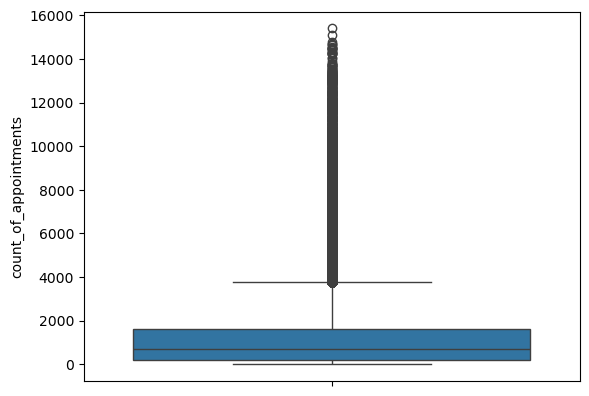

In [19]:
# Outlier check
sns.boxplot(y=ad['count_of_appointments'])

**NOTE: This looks like lots of outliers but that's not an issue given the nature of the data. Sub-ICB regions vary in terms of the number of GP practices and registered patients, and number of appointments with long durations will be relatively low.**

### ar DataFrame

In [20]:
view_data(ar)

DataFrame shape: (596821, 7)
DataFrame head:
<bound method NDFrame.head of        icb_ons_code appointment_month appointment_status hcp_type  \
0         E54000034           2020-01           Attended       GP   
1         E54000034           2020-01           Attended       GP   
2         E54000034           2020-01           Attended       GP   
3         E54000034           2020-01           Attended       GP   
4         E54000034           2020-01           Attended       GP   
...             ...               ...                ...      ...   
596816    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596818    E54000050           2022-06            Unknown  Unknown   
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
0          Face-to-Face            

**NOTE: I will probably need change 'time_between_book_and_appointment' to category type and set the order of the unique values for the visualisation to display properly.**

In [21]:
validate_data(ar)

Unique values per column:
icb_ons_code                            42
appointment_month                       30
appointment_status                       3
hcp_type                                 3
appointment_mode                         5
time_between_book_and_appointment        8
count_of_appointments                22807
dtype: int64

Number of duplicate rows:
21604

Summary statistics:
       count_of_appointments
count          596821.000000
mean             1244.601857
std              5856.887042
min                 1.000000
25%                 7.000000
50%                47.000000
75%               308.000000
max            211265.000000


(icb_ons_code                            42
 appointment_month                       30
 appointment_status                       3
 hcp_type                                 3
 appointment_mode                         5
 time_between_book_and_appointment        8
 count_of_appointments                22807
 dtype: int64,
 21604,
        count_of_appointments
 count          596821.000000
 mean             1244.601857
 std              5856.887042
 min                 1.000000
 25%                 7.000000
 50%                47.000000
 75%               308.000000
 max            211265.000000)

**The duplicate rows are not suprising because this data used to be more granular (daily vs. monthly, sub-icb level vs. icb level). My assumption is that some rows that appear to duplicates are actually from different days and/or sub-icb levels. For this reason I am keeping the duplicates.**

<Axes: ylabel='count_of_appointments'>

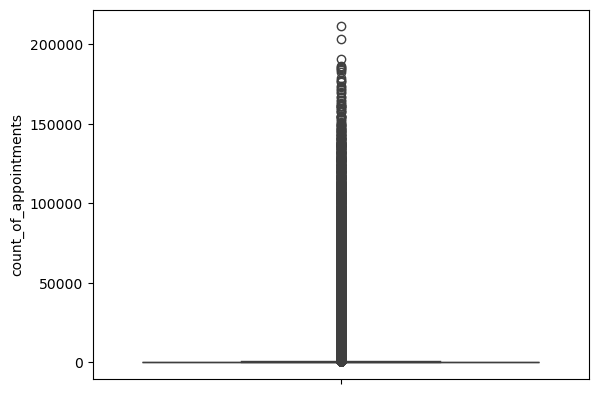

In [22]:
# Outlier check
sns.boxplot(y=ar['count_of_appointments'])

**NOTE: This looks like lots of outliers but that's not an issue given the nature of the data. It's expected that most appointment counts will be low but some will be quite high because of different ways of reporting counts for different appointment modes (home visit vs. face-to-face, for example.)**

### nc DataFrame

In [23]:
view_data(nc)

DataFrame shape: (817394, 8)
DataFrame head:
<bound method NDFrame.head of        appointment_date icb_ons_code  \
0            2021-08-02    E54000050   
1            2021-08-02    E54000050   
2            2021-08-02    E54000050   
3            2021-08-02    E54000050   
4            2021-08-02    E54000050   
...                 ...          ...   
817389       2022-06-30    E54000054   
817390       2022-06-30    E54000054   
817391       2022-06-30    E54000054   
817392       2022-06-30    E54000054   
817393       2022-06-30    E54000054   

                             sub_icb_location_name            service_setting  \
0       NHS North East and North Cumbria ICB - 00L       Primary Care Network   
1       NHS North East and North Cumbria ICB - 00L                      Other   
2       NHS North East and North Cumbria ICB - 00L           General Practice   
3       NHS North East and North Cumbria ICB - 00L           General Practice   
4       NHS North East and North Cumbri

In [24]:
validate_data(nc)

Unique values per column:
appointment_date          334
icb_ons_code               42
sub_icb_location_name     106
service_setting             5
context_type                3
national_category          18
count_of_appointments    9957
appointment_month          11
dtype: int64

Number of duplicate rows:
0

Summary statistics:
                    appointment_date  count_of_appointments
count                         817394          817394.000000
mean   2022-01-16 00:50:35.860796160             362.183684
min              2021-08-01 00:00:00               1.000000
25%              2021-10-25 00:00:00               7.000000
50%              2022-01-18 00:00:00              25.000000
75%              2022-04-07 00:00:00             128.000000
max              2022-06-30 00:00:00           16590.000000
std                              NaN            1084.576600


(appointment_date          334
 icb_ons_code               42
 sub_icb_location_name     106
 service_setting             5
 context_type                3
 national_category          18
 count_of_appointments    9957
 appointment_month          11
 dtype: int64,
 0,
                     appointment_date  count_of_appointments
 count                         817394          817394.000000
 mean   2022-01-16 00:50:35.860796160             362.183684
 min              2021-08-01 00:00:00               1.000000
 25%              2021-10-25 00:00:00               7.000000
 50%              2022-01-18 00:00:00              25.000000
 75%              2022-04-07 00:00:00             128.000000
 max              2022-06-30 00:00:00           16590.000000
 std                              NaN            1084.576600)

**Only 11 unique values for 'appointment_month' caught my attention but the data only covers August 2021 - June 2022.**

<Axes: ylabel='count_of_appointments'>

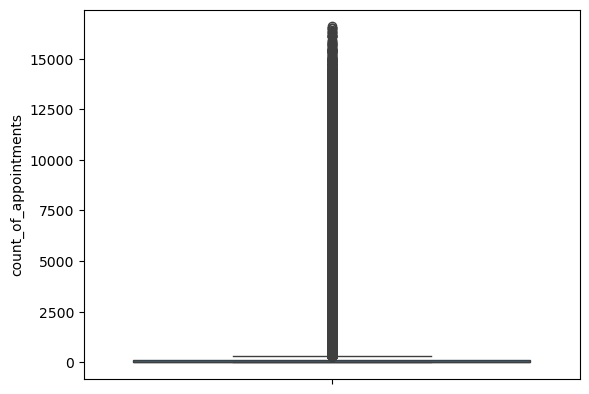

In [25]:
# Outlier check
sns.boxplot(y=nc['count_of_appointments'])

**NOTE: This looks like lots of outliers but that's not an issue given the nature of the data. It's expected that most appointment counts will be low but some will be quite high because of different ways of reporting counts for different categories of appointments (home visit vs.  routine general consultatione, for example.)**

### tweets DataFrame

In [26]:
view_data(tweets)

DataFrame shape: (1174, 10)
DataFrame head:
<bound method NDFrame.head of                  tweet_id                                    tweet_full_text  \
0     1567629223795527681  As Arkansas’ first Comprehensive Stroke Certif...   
1     1567582846612553728  RT @AndreaGrammer: Work-life balance is at the...   
2     1567582787070304256  RT @OntarioGreens: $10 billion can go a long w...   
3     1567582767625428992  RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...   
4     1567582720460570625  ICYMI: Our recent blogs on Cybersecurity in Ac...   
...                   ...                                                ...   
1169  1567583004209332227  RT @PotomacPhotonic: Potomac #Innovation Repor...   
1170  1567582945342267393  Not a cent towards workers who would like to a...   
1171  1567582936014241792  The @hfmaorg Region 9 presents "The Value of E...   
1172  1567582892892782592  Happy physiotherapy 🩺 day 🎉..\n#bpt #physiothe...   
1173  1567582846847533058  RT @KimcoStaffing: 

In [27]:
validate_data(tweets)

Unique values per column:
tweet_id                   1174
tweet_full_text             961
tweet_entities              945
tweet_entities_hashtags     710
tweet_metadata                1
tweet_retweet_count          47
tweet_favorite_count         20
tweet_favorited               1
tweet_retweeted               1
tweet_lang                    1
dtype: int64

Number of duplicate rows:
0

Summary statistics:
           tweet_id  tweet_retweet_count  tweet_favorite_count
count  1.174000e+03          1174.000000            1174.00000
mean   1.567612e+18             8.629472               0.37138
std    2.427553e+13            29.784675               2.04470
min    1.567574e+18             0.000000               0.00000
25%    1.567590e+18             0.000000               0.00000
50%    1.567611e+18             1.000000               0.00000
75%    1.567633e+18             3.000000               0.00000
max    1.567655e+18           303.000000              42.00000


(tweet_id                   1174
 tweet_full_text             961
 tweet_entities              945
 tweet_entities_hashtags     710
 tweet_metadata                1
 tweet_retweet_count          47
 tweet_favorite_count         20
 tweet_favorited               1
 tweet_retweeted               1
 tweet_lang                    1
 dtype: int64,
 0,
            tweet_id  tweet_retweet_count  tweet_favorite_count
 count  1.174000e+03          1174.000000            1174.00000
 mean   1.567612e+18             8.629472               0.37138
 std    2.427553e+13            29.784675               2.04470
 min    1.567574e+18             0.000000               0.00000
 25%    1.567590e+18             0.000000               0.00000
 50%    1.567611e+18             1.000000               0.00000
 75%    1.567633e+18             3.000000               0.00000
 max    1.567655e+18           303.000000              42.00000)

<Axes: ylabel='tweet_retweet_count'>

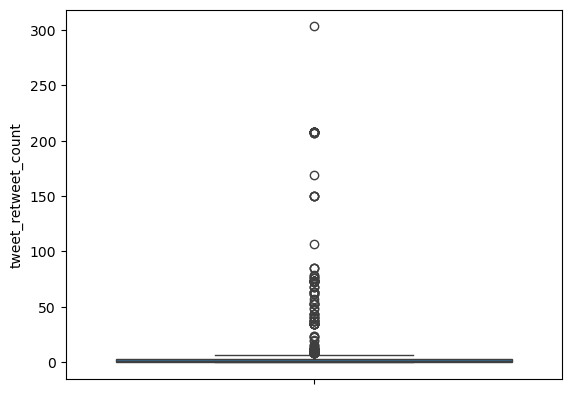

In [28]:
# Outlier check
sns.boxplot(y=tweets['tweet_retweet_count'])

<Axes: ylabel='tweet_favorite_count'>

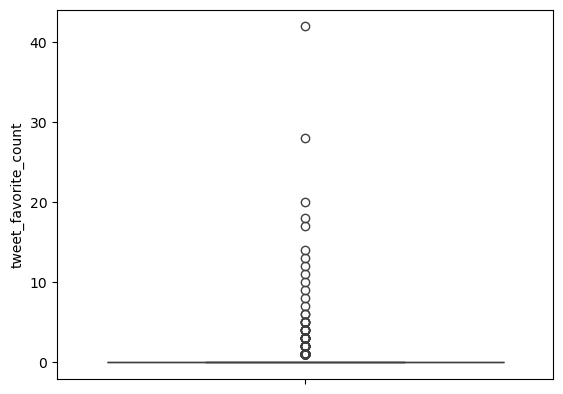

In [29]:
# Outlier check
sns.boxplot(y=tweets['tweet_favorite_count'])

**In the context of this dataframe where each row represents a single tweet and the majority of tweets have 0 retweets and/or favorites, the shape of the boxplots and the number outliers suggests that these columns will not yield valuable insights.**

### gp_icb DataFrame

In [30]:
view_data(gp_icb)

DataFrame shape: (16458, 27)
DataFrame head:
<bound method NDFrame.head of            0                                     1    2    3   \
0      A81001                   THE DENSHAM SURGERY  Y63  QHM   
1      A81002            QUEENS PARK MEDICAL CENTRE  Y63  QHM   
2      A81003             VICTORIA MEDICAL PRACTICE  Y54  Q74   
3      A81004                 ACKLAM MEDICAL CENTRE  Y63  QHM   
4      A81005                    SPRINGWOOD SURGERY  Y63  QHM   
...       ...                                   ...  ...  ...   
16453  Y08609                   KING CROSS PHARMACY  Y63  QWO   
16454  Y08610                       SAHARA PHARMACY  Y63  QWO   
16455  Y08611   PES @ PLECK EYE CARE CENTRE, BC ICB  Y60  QUA   
16456  Y08612  HELP FOR PSYCHOLOGY SERVICES LIMITED  Y61  QMM   
16457  Y08613                          HMP MILLSIKE  Y63  Q99   

                            4                          5                 6   \
0            THE HEALTH CENTRE              LAWSON STREET  STOCKT

**NOTE: Dataset lacks header; need to re-load and create header.**

### pat_month DataFrame

In [31]:
view_data(pat_month)

DataFrame shape: (30, 2)
DataFrame head:
<bound method NDFrame.head of    appointment_month  reg_patients
0         2020-01-01      60313139
1         2020-02-01      60356924
2         2020-03-01      60407381
3         2020-04-01      60384442
4         2020-05-01      60341661
5         2020-06-01      60347175
6         2020-07-01      60364596
7         2020-08-01      60406217
8         2020-09-01      60395280
9         2020-10-01      60443164
10        2020-11-01      60504906
11        2020-12-01      60556093
12        2021-01-01      60594653
13        2021-02-01      60607094
14        2021-03-01      60637877
15        2021-04-01      60734640
16        2021-05-01      60795907
17        2021-06-01      60849692
18        2021-07-01      60963439
19        2021-08-01      61025087
20        2021-09-01      61077857
21        2021-10-01      61190983
22        2021-11-01      61296468
23        2021-12-01      61390490
24        2022-01-01      61459083
25        2022-02-0

<Axes: ylabel='reg_patients'>

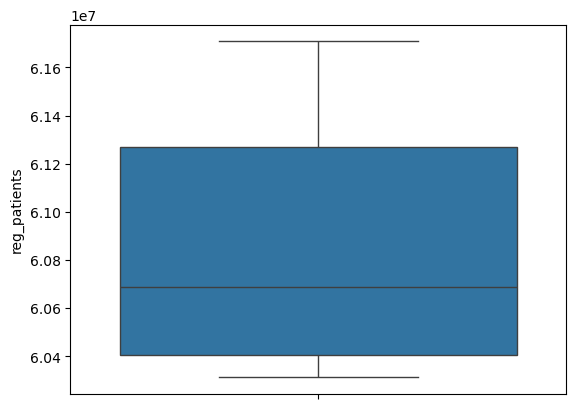

In [32]:
# Outlier check
sns.boxplot(y=pat_month['reg_patients'])

**This DataFrame looks fine.**

### pat DataFrame

In [33]:
view_data(pat)

DataFrame shape: (6495, 10)
DataFrame head:
<bound method NDFrame.head of            PUBLICATION EXTRACT_DATE TYPE CCG_CODE ONS_CCG_CODE    CODE  \
0     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84002   
1     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84005   
2     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84006   
3     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84007   
4     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84008   
...                ...          ...  ...      ...          ...     ...   
6490  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  B85660   
6491  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y00081   
6492  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y04266   
6493  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y06659   
6494  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y07275   

      POSTCODE  SEX  AGE  NUMBER_OF_P

**NOTE: I need to make columns lowercase and rename column that is equivalent to the sub-ICB code before merging**

In [34]:
validate_data(pat)

Unique values per column:
PUBLICATION              1
EXTRACT_DATE             1
TYPE                     1
CCG_CODE               106
ONS_CCG_CODE           106
CODE                  6495
POSTCODE              5918
SEX                      1
AGE                      1
NUMBER_OF_PATIENTS    5350
dtype: int64

Number of duplicate rows:
0

Summary statistics:
       NUMBER_OF_PATIENTS
count         6495.000000
mean          9501.996305
std           6477.921607
min              1.000000
25%           5354.000000
50%           8236.000000
75%          11992.500000
max         110213.000000


(PUBLICATION              1
 EXTRACT_DATE             1
 TYPE                     1
 CCG_CODE               106
 ONS_CCG_CODE           106
 CODE                  6495
 POSTCODE              5918
 SEX                      1
 AGE                      1
 NUMBER_OF_PATIENTS    5350
 dtype: int64,
 0,
        NUMBER_OF_PATIENTS
 count         6495.000000
 mean          9501.996305
 std           6477.921607
 min              1.000000
 25%           5354.000000
 50%           8236.000000
 75%          11992.500000
 max         110213.000000)

<Axes: ylabel='NUMBER_OF_PATIENTS'>

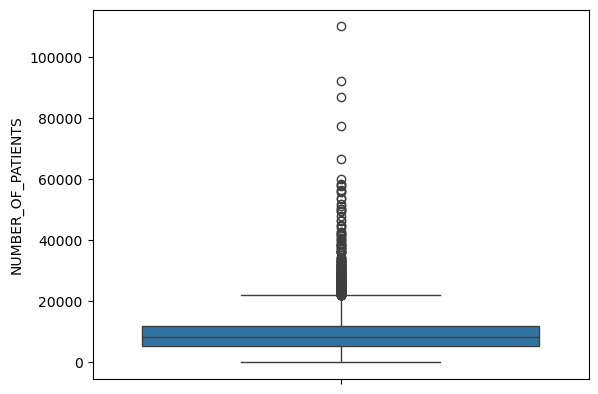

In [36]:
# Outlier check
sns.boxplot(y=pat['NUMBER_OF_PATIENTS'])

**The number of outliers is not a concern because the number of patients registered at a GP practice can vary widely and I will aggregating this data to the ICB level for my analysis.**

### icb_name DataFrame

In [37]:
view_data(icb_name)

DataFrame shape: (42, 3)
DataFrame head:
<bound method NDFrame.head of       ICB22CD ICB22CDH                                            ICB22NM
0   E54000008      QYG  NHS Cheshire and Merseyside Integrated Care Board
1   E54000010      QNC  NHS Staffordshire and Stoke-on-Trent Integrate...
2   E54000011      QOC  NHS Shropshire, Telford and Wrekin Integrated ...
3   E54000013      QJM             NHS Lincolnshire Integrated Care Board
4   E54000015      QK1  NHS Leicester, Leicestershire and Rutland Inte...
5   E54000018      QWU  NHS Coventry and Warwickshire Integrated Care ...
6   E54000019      QGH  NHS Herefordshire and Worcestershire Integrate...
7   E54000022      QMM     NHS Norfolk and Waveney Integrated Care Board 
8   E54000023      QJG  NHS Suffolk and North East Essex Integrated Ca...
9   E54000024      QHG  NHS Bedfordshire, Luton and Milton Keynes Inte...
10  E54000025      QM7  NHS Hertfordshire and West Essex Integrated Ca...
11  E54000026      QH8      NHS Mid and S

**NOTE: The columns need to be renamed before merging.**

### gp_imd DataFrame

In [38]:
view_data(gp_imd)

DataFrame shape: (134089, 3)
DataFrame head:
<bound method NDFrame.head of        Practice.Code        IMD  Year
0             A81001  25.075122  2010
1             A81001  25.888160  2011
2             A81001  26.701198  2012
3             A81001  27.514235  2013
4             A81001  28.327273  2014
...              ...        ...   ...
134084        Y06275  50.121059  2021
134085        Y06275  50.121059  2022
134086        Y06275  50.121059  2023
134087        Y06275  50.121059  2024
134088        Y06275  50.121059  2025

[134089 rows x 3 columns]>
DataFrame data types:
Practice.Code     object
IMD              float64
Year               int64
dtype: object


**Note: I will need to filter for the years the provided data covers (2020-2022) and merge with ICB ONS codes to eventually merge with data from 'appointments_regional'.**

In [39]:
validate_data(gp_imd)

Unique values per column:
Practice.Code     8461
IMD              74599
Year                16
dtype: int64

Number of duplicate rows:
0

Summary statistics:
                 IMD           Year
count  134089.000000  134089.000000
mean       24.117424    2017.549702
std        12.051038       4.600293
min         2.595314    2010.000000
25%        14.211160    2014.000000
50%        22.246960    2018.000000
75%        32.166187    2022.000000
max        68.875204    2025.000000


(Practice.Code     8461
 IMD              74599
 Year                16
 dtype: int64,
 0,
                  IMD           Year
 count  134089.000000  134089.000000
 mean       24.117424    2017.549702
 std        12.051038       4.600293
 min         2.595314    2010.000000
 25%        14.211160    2014.000000
 50%        22.246960    2018.000000
 75%        32.166187    2022.000000
 max        68.875204    2025.000000)

<Axes: ylabel='IMD'>

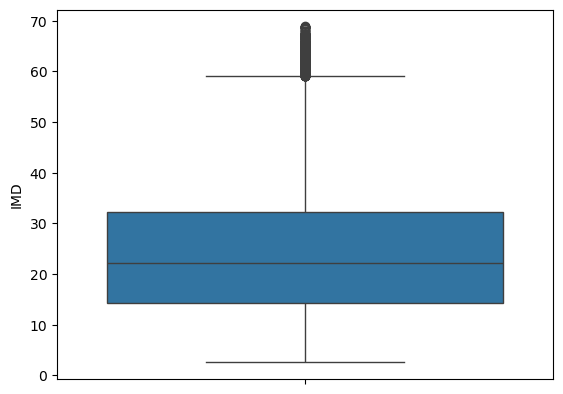

In [40]:
sns.boxplot(y=gp_imd['IMD'])

### gp DataFrame

In [41]:
view_data(gp)

DataFrame shape: (194675, 19)
DataFrame head:
<bound method NDFrame.head of         YEAR  Month COMM_REGION_CODE COMM_REGION_NAME ICB_CODE  \
0       2022      6              Y56           London      QRV   
1       2022      6              Y61  East of England      QMM   
2       2022      6              Y61  East of England      QMM   
3       2022      6              Y59       South East      QKS   
4       2022      6              Y61  East of England      QHG   
...      ...    ...              ...              ...      ...   
194670  2022      6              Y56           London      QRV   
194671  2022      6              Y56           London      QRV   
194672  2022      6              Y56           London      QRV   
194673  2022      6              Y56           London      QRV   
194674  2022      6              Y56           London      QRV   

                                             ICB_NAME SUB_ICB_CODE  \
0                           NHS North West London ICB        

**NOTE: I will need to make column names lowercase before merging. Several columns are missing data but those columns are not relevant to my analysis.**

In [42]:
validate_data(gp)

Unique values per column:
YEAR                                1
Month                               1
COMM_REGION_CODE                    8
COMM_REGION_NAME                    8
ICB_CODE                           43
ICB_NAME                           43
SUB_ICB_CODE                      107
SUB_ICB_NAME                      107
DATA_SOURCE                         3
UNIQUE_IDENTIFIER              189604
STAFF_GROUP                         5
DETAILED_STAFF_ROLE                54
STAFF_ROLE                         42
COUNTRY_QUALIFICATION_AREA         13
COUNTRY_QUALIFICATION_GROUP         5
AGE_BAND                           12
AGE_YEARS                          76
GENDER                              3
FTE                              1344
dtype: int64

Number of duplicate rows:
612

Summary statistics:
           YEAR     Month      AGE_YEARS            FTE
count  194675.0  194675.0  191913.000000  194675.000000
mean     2022.0       6.0      46.407612       0.722057
std         0.0    

(YEAR                                1
 Month                               1
 COMM_REGION_CODE                    8
 COMM_REGION_NAME                    8
 ICB_CODE                           43
 ICB_NAME                           43
 SUB_ICB_CODE                      107
 SUB_ICB_NAME                      107
 DATA_SOURCE                         3
 UNIQUE_IDENTIFIER              189604
 STAFF_GROUP                         5
 DETAILED_STAFF_ROLE                54
 STAFF_ROLE                         42
 COUNTRY_QUALIFICATION_AREA         13
 COUNTRY_QUALIFICATION_GROUP         5
 AGE_BAND                           12
 AGE_YEARS                          76
 GENDER                              3
 FTE                              1344
 dtype: int64,
 612,
            YEAR     Month      AGE_YEARS            FTE
 count  194675.0  194675.0  191913.000000  194675.000000
 mean     2022.0       6.0      46.407612       0.722057
 std         0.0       0.0      12.775241       0.250667
 min      

In [43]:
# Investigate duplicates
gp_duplicates = gp[gp.duplicated()]
gp_duplicates

,YEAR,Month,COMM_REGION_CODE,COMM_REGION_NAME,ICB_CODE,ICB_NAME,SUB_ICB_CODE,SUB_ICB_NAME,DATA_SOURCE,UNIQUE_IDENTIFIER,STAFF_GROUP,DETAILED_STAFF_ROLE,STAFF_ROLE,COUNTRY_QUALIFICATION_AREA,COUNTRY_QUALIFICATION_GROUP,AGE_BAND,AGE_YEARS,GENDER,FTE
14197,2022,6,Y62,North West,QYG,NHS Cheshire and Merseyside ICB,99A,NHS Cheshire and Merseyside ICB - 99A Liverpool,Provided,52597,GP,Partner/Provider,GP Partners,UK,UK,45-49,48.0,Male,0.250000
15070,2022,6,Y62,North West,QOP,NHS Greater Manchester ICB,14L,NHS Greater Manchester ICB - 14L Manchester,Provided,6034,Nurses,Practice Nurse,Practice Nurses,Not Applicable,Not Applicable,45-49,46.0,Female,0.120000
16636,2022,6,Y59,South East,QNX,NHS Sussex ICB,70F,NHS Sussex ICB - 70F West Sussex,Provided,91872,GP,Salaried By Practice,Salaried GPs,UK,UK,30-34,32.0,Female,0.640000
18875,2022,6,Y60,Midlands,QWU,NHS Coventry and Warwickshire ICB,B2M3M,NHS Coventry and Warwickshire ICB - B2M3M,Provided,135915,Admin/Non-Clinical,Medical Secretary,Medical Secretaries,Not Applicable,Not Applicable,40-44,42.0,Female,0.170667
20260,2022,6,Y60,Midlands,QHL,NHS Birmingham and Solihull ICB,15E,NHS Birmingham and Solihull ICB - 15E,Provided,83137,GP,Locum - other,GP Regular Locums,UK,UK,40-44,41.0,Female,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193218,2022,6,Y56,London,QWE,NHS South West London ICB,36L,NHS South West London ICB - 36L,Provided,23210,GP,Partner/Provider,GP Partners,Europe other,Elsewhere,45-49,45.0,Male,1.000000
193264,2022,6,Y62,North West,QOP,NHS Greater Manchester ICB,01Y,NHS Greater Manchester ICB - 01Y Tameside and ...,Provided,124475,Admin/Non-Clinical,Manager,Managers,Not Applicable,Not Applicable,65 and over,65.0,Female,0.906667
193281,2022,6,Y63,North East and Yorkshire,QHM,NHS North East and North Cumbria ICB,16C,NHS North East and North Cumbria ICB - 16C Tee...,Provided,170127,Admin/Non-Clinical,Receptionist,Receptionists,Not Applicable,Not Applicable,Under 25,23.0,Female,0.986667
193283,2022,6,Y63,North East and Yorkshire,QHM,NHS North East and North Cumbria ICB,16C,NHS North East and North Cumbria ICB - 16C Tee...,Provided,144933,Admin/Non-Clinical,Manager,Managers,Not Applicable,Not Applicable,55-59,57.0,Female,1.000000


**NOTE: The number of duplicates is relatively small (less than 1% of the row count) and do not appear to be concentrated in a specific region so I will keep them.**

<Axes: ylabel='FTE'>

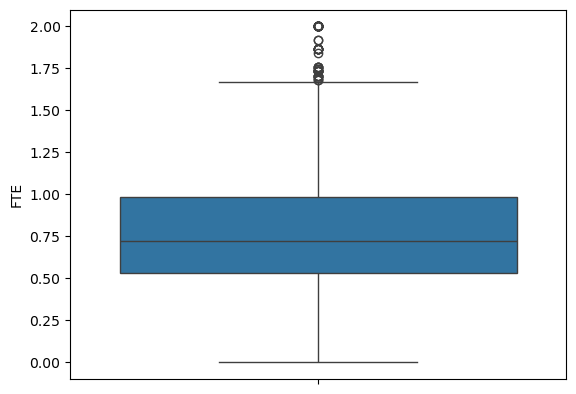

In [44]:
sns.boxplot(y=gp['FTE'])

**NOTE: It is possible for a GP to be 2.0 full-time equivalent (FTE) if they work 75 hours or more per week. See: [GPs question 'double counting' in full-time equivalent workforce data](https://www.gponline.com/gps-question-double-counting-full-time-equivalent-workforce-data/article/1419280)**

### working_day DataFrame

In [45]:
view_data(working_days)

DataFrame shape: (30, 2)
DataFrame head:
<bound method NDFrame.head of    appointment_month  working_days
0         2020-01-01            22
1         2020-02-01            20
2         2020-03-01            22
3         2020-04-01            20
4         2020-05-01            19
5         2020-06-01            22
6         2020-07-01            23
7         2020-08-01            20
8         2020-09-01            22
9         2020-10-01            22
10        2020-11-01            21
11        2020-12-01            21
12        2021-01-01            20
13        2021-02-01            20
14        2021-03-01            23
15        2021-04-01            20
16        2021-05-01            19
17        2021-06-01            22
18        2021-07-01            22
19        2021-08-01            21
20        2021-09-01            22
21        2021-10-01            21
22        2021-11-01            22
23        2021-12-01            21
24        2022-01-01            20
25        2022-02-0

**This DataFrame looks fine.**

## Data Cleaning and Transformation

### Rename Column Headers of icb_name for Merging

In [46]:
# Rename columns of icb_name for merging
icb_rename = icb_name.rename(columns={'ICB22CD': 'icb_ons_code', 'ICB22CDH': 'icb_code','ICB22NM': 'icb_name'})

# View renamed dataframe
view_data(icb_rename)

DataFrame shape: (42, 3)
DataFrame head:
<bound method NDFrame.head of    icb_ons_code icb_code                                           icb_name
0     E54000008      QYG  NHS Cheshire and Merseyside Integrated Care Board
1     E54000010      QNC  NHS Staffordshire and Stoke-on-Trent Integrate...
2     E54000011      QOC  NHS Shropshire, Telford and Wrekin Integrated ...
3     E54000013      QJM             NHS Lincolnshire Integrated Care Board
4     E54000015      QK1  NHS Leicester, Leicestershire and Rutland Inte...
5     E54000018      QWU  NHS Coventry and Warwickshire Integrated Care ...
6     E54000019      QGH  NHS Herefordshire and Worcestershire Integrate...
7     E54000022      QMM     NHS Norfolk and Waveney Integrated Care Board 
8     E54000023      QJG  NHS Suffolk and North East Essex Integrated Ca...
9     E54000024      QHG  NHS Bedfordshire, Luton and Milton Keynes Inte...
10    E54000025      QM7  NHS Hertfordshire and West Essex Integrated Ca...
11    E54000026  

**The new column names now match those in the dataframes to be merged.**

### Create Header for gp_icb DataFrame

In [47]:
# Reload csv with no header
gp_icb = pd.read_csv('epraccur.csv', header=None)

# Create header
gp_icb_header = gp_icb.rename(columns={0: 'Practice.Code', 3: 'icb_code'})

# View dataframe
view_data(gp_icb_header)

DataFrame shape: (16458, 27)
DataFrame head:
<bound method NDFrame.head of       Practice.Code                                     1    2 icb_code  \
0            A81001                   THE DENSHAM SURGERY  Y63      QHM   
1            A81002            QUEENS PARK MEDICAL CENTRE  Y63      QHM   
2            A81003             VICTORIA MEDICAL PRACTICE  Y54      Q74   
3            A81004                 ACKLAM MEDICAL CENTRE  Y63      QHM   
4            A81005                    SPRINGWOOD SURGERY  Y63      QHM   
...             ...                                   ...  ...      ...   
16453        Y08609                   KING CROSS PHARMACY  Y63      QWO   
16454        Y08610                       SAHARA PHARMACY  Y63      QWO   
16455        Y08611   PES @ PLECK EYE CARE CENTRE, BC ICB  Y60      QUA   
16456        Y08612  HELP FOR PSYCHOLOGY SERVICES LIMITED  Y61      QMM   
16457        Y08613                          HMP MILLSIKE  Y63      Q99   

                        

**The new column names now match those in the dataframes to be merged.**

### Make gp and pat Column Headers Lowercase for Merging

In [48]:
# Make gp columns lower case
gp.columns = gp.columns.str.lower()
view_data(gp)

DataFrame shape: (194675, 19)
DataFrame head:
<bound method NDFrame.head of         year  month comm_region_code comm_region_name icb_code  \
0       2022      6              Y56           London      QRV   
1       2022      6              Y61  East of England      QMM   
2       2022      6              Y61  East of England      QMM   
3       2022      6              Y59       South East      QKS   
4       2022      6              Y61  East of England      QHG   
...      ...    ...              ...              ...      ...   
194670  2022      6              Y56           London      QRV   
194671  2022      6              Y56           London      QRV   
194672  2022      6              Y56           London      QRV   
194673  2022      6              Y56           London      QRV   
194674  2022      6              Y56           London      QRV   

                                             icb_name sub_icb_code  \
0                           NHS North West London ICB        

In [49]:
# Make pat columns lower case
pat.columns = pat.columns.str.lower()
view_data(pat)

DataFrame shape: (6495, 10)
DataFrame head:
<bound method NDFrame.head of            publication extract_date type ccg_code ons_ccg_code    code  \
0     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84002   
1     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84005   
2     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84006   
3     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84007   
4     GP_PRAC_PAT_LIST    01Jun2022   GP      00L    E38000130  A84008   
...                ...          ...  ...      ...          ...     ...   
6490  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  B85660   
6491  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y00081   
6492  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y04266   
6493  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y06659   
6494  GP_PRAC_PAT_LIST    01Jun2022   GP    X2C4Y    E38000254  Y07275   

      postcode  sex  age  number_of_p

### Preparing DataFrame for Regional Deprivation and Appointment Attendance Scatter Plot

**The regional deprivation dataframe is organised by gp practice and contains data for multiple years. Before merging this dataframe with the attended appointment percentages, I need to add the ICB code, filter the data for the relevant years, group by ICB code and aggregate the deprivation score as an average across the selected years, and then add the ICB ONS code.**

In [50]:
# Add icb_code via merge
imd_icb = pd.merge(gp_imd, gp_icb_header[['Practice.Code', 'icb_code']], on='Practice.Code', how='left')

# Convert year to datetime
imd_icb['Year'] = pd.to_datetime(imd_icb['Year'], format='%Y')

# Filter data for date range of provided data
filtered_imd_icb = imd_icb.loc[(imd_icb['Year'] >= '2020') & (imd_icb['Year'] < '2023')]

# Group by ICB and average the IMD score
gb_icb_imd = filtered_imd_icb.groupby(filtered_imd_icb['icb_code'])[['IMD']].mean().reset_index()

# Add icb_ons code via merge with icb_rename
imd_ons = pd.merge(icb_rename, gb_icb_imd, on='icb_code', how='left')

# View dataframe
view_data(imd_ons)

DataFrame shape: (42, 4)
DataFrame head:
<bound method NDFrame.head of    icb_ons_code icb_code                                           icb_name  \
0     E54000008      QYG  NHS Cheshire and Merseyside Integrated Care Board   
1     E54000010      QNC  NHS Staffordshire and Stoke-on-Trent Integrate...   
2     E54000011      QOC  NHS Shropshire, Telford and Wrekin Integrated ...   
3     E54000013      QJM             NHS Lincolnshire Integrated Care Board   
4     E54000015      QK1  NHS Leicester, Leicestershire and Rutland Inte...   
5     E54000018      QWU  NHS Coventry and Warwickshire Integrated Care ...   
6     E54000019      QGH  NHS Herefordshire and Worcestershire Integrate...   
7     E54000022      QMM     NHS Norfolk and Waveney Integrated Care Board    
8     E54000023      QJG  NHS Suffolk and North East Essex Integrated Ca...   
9     E54000024      QHG  NHS Bedfordshire, Luton and Milton Keynes Inte...   
10    E54000025      QM7  NHS Hertfordshire and West Essex I

**The dataframe is now ready to be merged with attended appointment percentage data.**

In [51]:
# Merge IMD data with ICB attended appt percentages
imd_attd = pd.merge(imd_ons, attd_icb_ons_code, on='icb_ons_code', how='left')
view_data(imd_attd)

DataFrame shape: (42, 7)
DataFrame head:
<bound method NDFrame.head of    icb_ons_code icb_code                                           icb_name  \
0     E54000008      QYG  NHS Cheshire and Merseyside Integrated Care Board   
1     E54000010      QNC  NHS Staffordshire and Stoke-on-Trent Integrate...   
2     E54000011      QOC  NHS Shropshire, Telford and Wrekin Integrated ...   
3     E54000013      QJM             NHS Lincolnshire Integrated Care Board   
4     E54000015      QK1  NHS Leicester, Leicestershire and Rutland Inte...   
5     E54000018      QWU  NHS Coventry and Warwickshire Integrated Care ...   
6     E54000019      QGH  NHS Herefordshire and Worcestershire Integrate...   
7     E54000022      QMM     NHS Norfolk and Waveney Integrated Care Board    
8     E54000023      QJG  NHS Suffolk and North East Essex Integrated Ca...   
9     E54000024      QHG  NHS Bedfordshire, Luton and Milton Keynes Inte...   
10    E54000025      QM7  NHS Hertfordshire and West Essex I

### Preparing Dataframe for Appointments Time Series

**The NHS and other organisations tend to report appointment data in terms of appointments per working day. To prepare the data for visualisation, I group appointment counts by month, merge the provided data with a dataset that contains the number of working days for each month and then create a calculated column for appointments per working day.**

In [52]:
# Group by month and appointment status
month_appt = ar.groupby([ar['appointment_month']])[['count_of_appointments']].sum().reset_index()

# Change month data type to datetime
month_appt['appointment_month'] = pd.to_datetime(month_appt['appointment_month'])

# Load working days dataset
wd = pd.read_excel('working_days.xlsx')

# Merge datasets
appt_wd = pd.merge(month_appt, wd, on='appointment_month', how='left')

# Calculate appointments per working day
appt_wd['appt_per_day'] = (appt_wd['count_of_appointments'] / appt_wd['working_days'])

# Drop extra columns
appt_wd = appt_wd.drop(columns=['count_of_appointments', 'working_days'])

# Set date as the index
appt_wd.set_index('appointment_month', inplace=True)
                              
# View dataframe
appt_wd

,appt_per_day
appointment_month,
2020-01-01,1.236332e+06
2020-02-01,1.205231e+06
2020-03-01,1.093339e+06
2020-04-01,8.003941e+05
2020-05-01,8.640638e+05
2020-06-01,9.404911e+05
2020-07-01,9.778886e+05
2020-08-01,1.007526e+06
2020-09-01,1.214284e+06


**NOTE: Appointments for the months from September 2021 are above or near max capacity of 1.2 million per (working) day.**

### Preparing Dataframe for Attended Appointments Time Series

**The NHS and other organisations tend to report appointment data in terms of appointments per working day. To prepare the data for visualisation, I group attended appointment counts by month, merge the provided data with a dataset that contains the number of working days for each month and then create a calculated column for attended appointments per working day.**

In [53]:
# Group by month and appointment status
month_status = ar.groupby([ar['appointment_month'], ar['appointment_status']])[['count_of_appointments']].sum().reset_index()

# Filter for attended appointments
month_attd = month_status[month_status['appointment_status'] == 'Attended']

# Change month data type to datetime
month_attd['appointment_month'] = pd.to_datetime(month_attd['appointment_month'])

# Load working days dataset
wd = pd.read_excel('working_days.xlsx')

# Merge datasets
attd_wd = pd.merge(month_attd, wd, on='appointment_month', how='left')

# Calculate attended appointments per working day
attd_wd['attd_per_day'] = (attd_wd['count_of_appointments'] / attd_wd['working_days'])

# Drop extra columns
attd_wd = attd_wd.drop(columns=['count_of_appointments', 'appointment_status', 'working_days'])

# Set date as the index
attd_wd.set_index('appointment_month', inplace=True)
                              
# View dataframe
attd_wd

/var/folders/hk/dv8kkk0x06n17jn62mhyd1cw0000gn/T/ipykernel_53607/2706834263.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_attd['appointment_month'] = pd.to_datetime(month_attd['appointment_month'])


,attd_per_day
appointment_month,
2020-01-01,1.115377e+06
2020-02-01,1.082003e+06
2020-03-01,9.417666e+05
2020-04-01,6.991412e+05
2020-05-01,7.875184e+05
2020-06-01,8.610465e+05
2020-07-01,8.959517e+05
2020-08-01,9.219466e+05
2020-09-01,1.090386e+06


**Attended appointments for the months from December 2021 are below or near max capacity.**

### Preparing DataFrame for Total Registered Patients Time Series

In [54]:
# Set date as the index
pat_month.set_index('appointment_month', inplace=True)

### Preparing DataFrame for Registered Patients and Appointment Count Scatterplot

In [55]:
# Merge pat_month with appt_wd
pat_appt = pd.merge(pat_month, appt_wd, on='appointment_month', how='left')
pat_appt

,reg_patients,appt_per_day
appointment_month,,
2020-01-01,60313139,1.236332e+06
2020-02-01,60356924,1.205231e+06
2020-03-01,60407381,1.093339e+06
2020-04-01,60384442,8.003941e+05
2020-05-01,60341661,8.640638e+05
2020-06-01,60347175,9.404911e+05
2020-07-01,60364596,9.778886e+05
2020-08-01,60406217,1.007526e+06
2020-09-01,60395280,1.214284e+06


### Preparing DataFrame for ICB Patient:GP Ratio and Appointment Attendance Scatterplot

**The first step is to merge the gp and pat dataframes to calculate the patient:gp ratio for each ICB.**

In [56]:
# Filter for staff group = GP
filtered_gp = gp[gp['staff_group'] == 'GP']

# Group by sub-ICB, sum FTE whilst keeping ICB name, ICB code, and region name
grouped_gp = filtered_gp.groupby([filtered_gp['sub_icb_code'], filtered_gp['icb_code'],
                                  filtered_gp['icb_name'], filtered_gp['comm_region_name']])[['fte']].sum().reset_index()

# Rename key column for merge
patrn = pat.rename(columns={'ccg_code': 'sub_icb_code'})

# Group patients by Sub-ICB 
pat_subicb = patrn.groupby([patrn['sub_icb_code']])[['number_of_patients']].sum().reset_index()

# Merge [WAIT UNTIL PERFORMING FILTER, GROUP SUM ON GP DATA
gp_pat = pd.merge(grouped_gp,pat_subicb, on='sub_icb_code', how='left')

# Group by ICB, sum FTE and number of patients, keep ICB name and region name Columns
gp_pat_icb = gp_pat.groupby([gp_pat['icb_code'], gp_pat['icb_name'], gp_pat['comm_region_name']]).agg({'fte':'sum','number_of_patients':'sum'}).reset_index()

# New column with patient to GP ratio
gp_pat_icb['patients_per_gp'] = (gp_pat_icb['number_of_patients'] / gp_pat_icb['fte'])

#View data
view_data(gp_pat_icb)

DataFrame shape: (43, 6)
DataFrame head:
<bound method NDFrame.head of    icb_code                                           icb_name  \
0       QE1               NHS Lancashire and South Cumbria ICB   
1       QF7                            NHS South Yorkshire ICB   
2       QGH           NHS Herefordshire and Worcestershire ICB   
3       QH8                        NHS Mid and South Essex ICB   
4       QHG      NHS Bedfordshire, Luton and Milton Keynes ICB   
5       QHL                    NHS Birmingham and Solihull ICB   
6       QHM               NHS North East and North Cumbria ICB   
7       QJ2                       NHS Derby and Derbyshire ICB   
8       QJG               NHS Suffolk and North East Essex ICB   
9       QJK                                      NHS Devon ICB   
10      QJM                               NHS Lincolnshire ICB   
11      QK1      NHS Leicester, Leicestershire and Rutland ICB   
12      QKK                          NHS South East London ICB   
13   

In [57]:
# print patient count and FTE sums to validate data
print(gp_pat_icb['fte'].sum())
print(gp_pat_icb['number_of_patients'].sum())

35448.512348189
61715466.0


**The FTE sum is the same as what is reported for the June 2022 GP workforce summary (which suggests that NHS analysts also kept the duplicate rows) but the sum of appointments is 7271 more than the data the NHS reported for June 2022. This is a miniscule difference given the scale of the numbers so the difference should not affect the analysis. Now I need to create a new function-generated dataframe containing ICB attendance percentages for June 2022.**

In [58]:
# Filter ar by month = June 2022
# Filter data between two dates
ar_june22 = ar.loc[(ar['appointment_month'] == '2022-06')]

# Group ar by icb-ons code
ar_icb_june22 = ar_june22.groupby([ar_june22['icb_ons_code'], ar_june22['appointment_status']])[['count_of_appointments']] \
.sum().reset_index()

# Run function
columns_to_analyze = ['icb_ons_code']
calc_attd_pct_by_cols(ar_icb_june22, columns_to_analyze)

# Rename dataframe
attd_june22 = attd_icb_ons_code

# Re-run function with unfiltered dataframe to reset
columns_to_analyze = ['icb_ons_code', 'appointment_month', 'hcp_type',
                      'appointment_mode', 'time_between_book_and_appointment']
calc_attd_pct_by_cols(ar, columns_to_analyze)


Created DataFrame 'attd_icb_ons_code' for column 'icb_ons_code'
Shape: (42, 4)
--------------------------------------------------
   icb_ons_code  total_appointments  attended_appointments  \
0     E54000008             1128437                1019437   
1     E54000010              448258                 408697   
2     E54000011              221454                 203745   
3     E54000013              377275                 352799   
4     E54000015              547140                 509911   
5     E54000018              430449                 395947   
6     E54000019              409165                 380537   
7     E54000022              536530                 498998   
8     E54000023              458402                 428406   
9     E54000024              425927                 395358   
10    E54000025              616588                 569757   
11    E54000026              489805                 455876   
12    E54000027             1102597                1003813   
1

**It is now time to merge the patient:gp ratio dataframe with the attendance percentage for June 2022 dataframe.**

In [59]:
# Merge gp_pat_icb with icb_rename to add icb ons code
gp_pat_icb_code = pd.merge(gp_pat_icb, icb_rename[['icb_code', 'icb_ons_code']], on='icb_code', how='left')

# Merge gp_pat_icb_code with attendance percentage data for June 2022
gp_pat_attd = pd.merge(gp_pat_icb_code, attd_june22, on='icb_ons_code', how='left')

# View dataframe
view_data(gp_pat_attd)

DataFrame shape: (43, 10)
DataFrame head:
<bound method NDFrame.head of    icb_code                                           icb_name  \
0       QE1               NHS Lancashire and South Cumbria ICB   
1       QF7                            NHS South Yorkshire ICB   
2       QGH           NHS Herefordshire and Worcestershire ICB   
3       QH8                        NHS Mid and South Essex ICB   
4       QHG      NHS Bedfordshire, Luton and Milton Keynes ICB   
5       QHL                    NHS Birmingham and Solihull ICB   
6       QHM               NHS North East and North Cumbria ICB   
7       QJ2                       NHS Derby and Derbyshire ICB   
8       QJG               NHS Suffolk and North East Essex ICB   
9       QJK                                      NHS Devon ICB   
10      QJM                               NHS Lincolnshire ICB   
11      QK1      NHS Leicester, Leicestershire and Rutland ICB   
12      QKK                          NHS South East London ICB   
13  

### Preparing DataFrame for ICB Patient:Clinical Staff Ratio and Appointment Attendance Scatterplot

In [60]:
# Filter for staff group != 'Admin/Non-Clinical'
filtered_clin = gp[gp['staff_group'] != 'Admin/Non-Clinical']

# Group by sub-ICB, sum FTE whilst keeping ICB name, ICB code, and region name
grouped_clin = filtered_clin.groupby([filtered_clin['sub_icb_code'], filtered_clin['icb_code'],
                                  filtered_clin['icb_name'], filtered_clin['comm_region_name']])[['fte']].sum().reset_index()

# Merge with patient dataframe
clin_pat = pd.merge(grouped_clin,pat_subicb, on='sub_icb_code', how='left')

# Group by ICB, sum FTE and number of patients, keep ICB name and region name Columns
clin_pat_icb = clin_pat.groupby([clin_pat['icb_code'], clin_pat['icb_name'], \
                                 clin_pat['comm_region_name']]).agg({'fte':'sum','number_of_patients':'sum'}).reset_index()

# New column with patient to clinical staff ratio
clin_pat_icb['patients_per_clin'] = (clin_pat_icb['number_of_patients'] / clin_pat_icb['fte'])

# Merge gp_pat_icb with icb_rename to add icb ons code
clin_pat_icb_code = pd.merge(clin_pat_icb, icb_rename[['icb_code', 'icb_ons_code']], on='icb_code', how='left')

# Merge gp_pat_icb_code with attendance percentage data for June 2022
clin_pat_attd = pd.merge(clin_pat_icb_code, attd_june22, on='icb_ons_code', how='left')

# View dataframe
view_data(clin_pat_attd)

DataFrame shape: (43, 10)
DataFrame head:
<bound method NDFrame.head of    icb_code                                           icb_name  \
0       QE1               NHS Lancashire and South Cumbria ICB   
1       QF7                            NHS South Yorkshire ICB   
2       QGH           NHS Herefordshire and Worcestershire ICB   
3       QH8                        NHS Mid and South Essex ICB   
4       QHG      NHS Bedfordshire, Luton and Milton Keynes ICB   
5       QHL                    NHS Birmingham and Solihull ICB   
6       QHM               NHS North East and North Cumbria ICB   
7       QJ2                       NHS Derby and Derbyshire ICB   
8       QJG               NHS Suffolk and North East Essex ICB   
9       QJK                                      NHS Devon ICB   
10      QJM                               NHS Lincolnshire ICB   
11      QK1      NHS Leicester, Leicestershire and Rutland ICB   
12      QKK                          NHS South East London ICB   
13  

### Preparing DataFrame for Time between Booking and Appointment Duration and Appointment Attendance Bar Plot

In [61]:
# View function-generated DataFrame
view_data(attd_time_between_book_and_appointment)

DataFrame shape: (8, 4)
DataFrame head:
<bound method NDFrame.head of   time_between_book_and_appointment  total_appointments  \
0                             1 Day            67716097   
1                    15  to 21 Days            42710574   
2                       2 to 7 Days           153794531   
3                    22  to 28 Days            25536541   
4                     8  to 14 Days            86846519   
5                 More than 28 Days            23050987   
6                          Same Day           342747171   
7            Unknown / Data Quality              402105   

   attended_appointments  attendance_percentage  
0               62556833                  92.38  
1               35842753                  83.92  
2              138103022                  89.80  
3               20798309                  81.45  
4               75092108                  86.47  
5               16699531                  72.45  
6              328380317                  95.81 

**Trial and error taught me to filter out unwanted rows before changing the data type to category.**

In [62]:
#Shorten dataframe name
attd_tbbaa = attd_time_between_book_and_appointment

# Remove extra spaces
attd_tbbaa.time_between_book_and_appointment = attd_tbbaa.time_between_book_and_appointment.str.replace('  ', ' ')

# Remove Unknown row
attd_tbbaa_filt = attd_tbbaa.loc[(attd_tbbaa['time_between_book_and_appointment'] != 'Unknown / Data Quality')]

# Change time_between_book_and_appointment to category
attd_tbbaa_filt = attd_tbbaa_filt.astype({'time_between_book_and_appointment':'category'})

# set order of category values
attd_tbbaa_filt['time_between_book_and_appointment'] = attd_tbbaa_filt['time_between_book_and_appointment'] \
    .cat.reorder_categories(['Same Day', '1 Day', '2 to 7 Days', '8 to 14 Days', '15 to 21 Days', \
                             '22 to 28 Days', 'More than 28 Days'], ordered=True)

attd_tbbaa_filt.sort_values(by=['time_between_book_and_appointment'])

,time_between_book_and_appointment,total_appointments,attended_appointments,attendance_percentage
6,Same Day,342747171,328380317,95.81
0,1 Day,67716097,62556833,92.38
2,2 to 7 Days,153794531,138103022,89.80
4,8 to 14 Days,86846519,75092108,86.47
1,15 to 21 Days,42710574,35842753,83.92
3,22 to 28 Days,25536541,20798309,81.45
5,More than 28 Days,23050987,16699531,72.45


### Preparing DataFrame for Healthcare Professional Type and Appointment Attendance Bar Plot

In [63]:
# Remove Unknown row
attd_hcp_type = attd_hcp_type.loc[(attd_hcp_type['hcp_type'] != 'Unknown')]

### Preparing DataFrame for Appointment Mode and Appointment Attendance Bar Plot

In [64]:
# Remove Unknown row
attd_appointment_mode = attd_appointment_mode.loc[(attd_appointment_mode['appointment_mode'] != 'Unknown')]

attd_appointment_mode.sort_values(by=['attendance_percentage'], ascending=False)

,appointment_mode,total_appointments,attended_appointments,attendance_percentage
2,Telephone,267862657,254799226,95.12
4,Video/Online,3620958,3303233,91.23
0,Face-to-Face,439981729,392705999,89.26
1,Home Visit,4887876,3612068,73.90


### Preparing DataFrame for Appointments per Day of the Week Bar Plot

**I need to add a column that provides the name of the day of the week based on the appointment_date column**

In [65]:
# Group by appointment day and sum count of appointments
nc_day = nc.groupby(nc['appointment_date'])[['count_of_appointments']] \
.sum().reset_index()

# Create new column with day names
nc_day['day_of_week'] = nc_day['appointment_date'].dt.day_name()

# Group by day names and sum appointment count
nc_day_of_week_mean = nc_day.groupby(nc_day['day_of_week'])[['count_of_appointments']] \
.mean().reset_index()

# Change time_between_book_and_appointment to category
nc_day_of_week_mean = nc_day_of_week_mean.astype({'day_of_week':'category'})

# set order of category values
nc_day_of_week_mean['day_of_week'] = nc_day_of_week_mean['day_of_week'] \
    .cat.reorder_categories(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', \
                             'Saturday', 'Sunday'], ordered=True)
nc_day_of_week_mean

,day_of_week,count_of_appointments
0,Friday,1.114784e+06
1,Monday,1.243651e+06
2,Saturday,1.186154e+05
3,Sunday,1.279502e+04
4,Thursday,1.187007e+06
5,Tuesday,1.287644e+06
6,Wednesday,1.228839e+06


### Preparing DataFrame for Appointment Duration Bar Plot

In [66]:
# Group by actual duration and sum count of appointments
ad_gb = ad.groupby(ad['actual_duration'])[['count_of_appointments']] \
.sum().reset_index()

# Remove Unknown row
ad_gb = ad_gb.loc[(ad_gb['actual_duration'] != 'Unknown / Data Quality')]

# Change time_between_book_and_appointment to category
ad_gb = ad_gb.astype({'actual_duration':'category'})

# set order of category values
ad_gb['actual_duration'] = ad_gb['actual_duration'] \
    .cat.reorder_categories(['1-5 Minutes', '6-10 Minutes', '11-15 Minutes', '16-20 Minutes', '21-30 Minutes', \
                             '31-60 Minutes'], ordered=True)

ad_gb.sort_values(by=['actual_duration'])

ad_gb['percent'] = (ad_gb['count_of_appointments'] / ad_gb['count_of_appointments'].sum()) * 100

ad_gb

,actual_duration,count_of_appointments,percent
0,1-5 Minutes,28600865,22.397514
1,11-15 Minutes,25160882,19.703642
2,16-20 Minutes,16004247,12.533025
3,21-30 Minutes,15026365,11.767239
4,31-60 Minutes,9103432,7.128954
5,6-10 Minutes,33800815,26.469627


## Data Exploration

### Twitter Data

**To determine whether any of the tweets were relevant to this analysis, I performed separate searches for the terms 'NHS', 'GP', and 'appointment'.**

In [67]:
# Keyword count and results for 'NHS'
print('Keyword Count:', keyword_count('NHS'))
print(keyword_results('NHS'))

Keyword Count: 3
200                                                                                             RT @LaunchpadDevon: @RDCareersNHS  Recruitment Event  Exeter – Saturday 17 September\n\nThis event is for anyone interested in roles availabl…
231                                                                                             RT @SkillsLaunchpad: Recruitment Event  Exeter – Saturday 17 September with @RDCareersNHS  \n\nFor anyone interested in #administration #heal…
450    HLA Scholar Thessa Rebecca Frieble from our Amsterdam cohort tells us what leadership means to her.\n\nhttps://t.co/Wt4ZmQ3H3z\n\n#HLAScholars #Leadership #HLA #Healthcare #NHS #doctor #Medical #Student #Nurse  #globalhealth #meded
Name: tweet_full_text, dtype: object


In [68]:
# Keyword count and results for 'GP'
print('Keyword Count:', keyword_count('GP'))
print(keyword_results('GP'))

Keyword Count: 11
72                                Do you know 1 in 5 manufacturing companies in the U.S. have been the victims of cyberattacks?\nKnow more about Hanu's security solution for manufacturing: https://t.co/XxaHGPSVSz\n#healthcare #business #datasecurity #compliance\nCloud Security Solutions | MSP Expert https://t.co/elTXf9PcDT
218                     A @femtechinsider article brief: At this year's Women’s Health Innovation Summit, @WomensHealth_US, 24 #startups are selected to pitch their solutions in front of industry #leaders and #investors.\nhttps://t.co/CK3HGpimT4\n#innovations #femtech #womenentrepreneurs #healthcare https://t.co/jDWTAbkhiy
275                                                                                     📢IQVIA the largest #Healthcare #Data #Science company chooses Nirmata!!!!! 📢#Kubernetes READ THE CASE STUDY HERE! #DevOps #medicine #kyverno #DevSecOps #healthcare #bigpharma\n⚕️👩‍🔬👨‍🔬 \n\nhttps://t.co/eMVYvqd8WR https://t.co/CURCvIIUXV
444    

In [69]:
# Keyword count and results for 'appointment'
print('Keyword Count:', keyword_count('appointment'))
print(keyword_results('appointment'))

Keyword Count: 8
47                                                                                                                                            RT @_timos_: Purespring Therapeutics strengthens scientific leadership with the appointment of Alice Brown as Chief Scientific Officer - Ya…
59      Purespring Therapeutics strengthens scientific leadership with the appointment of Alice Brown as Chief Scientific Officer - Yahoo Finance https://t.co/gyLsztiV0D #strategy #competitiveintelligence #marketing #pharma #healthcare #biotech #competitivemarketing #pharmaceutical
339                                                                                      Hiring Alert: Patient Service Representative (#Canton, Michigan) Dental Care Alliance #job #SchedulingAppointments #TreatmentPlanning #HealthCare https://t.co/obOiJBdaAY https://t.co/DiFIPWCJV5
346                                                                                 New Opportunity: Patient Service Representative (#

**Conclusion: None of the tweets with keywords were relevant to this analysis. That said, other kinds of unstructured data scraped from the web might be useful.**

## Data Visualisation

### Total Appointments Time Series

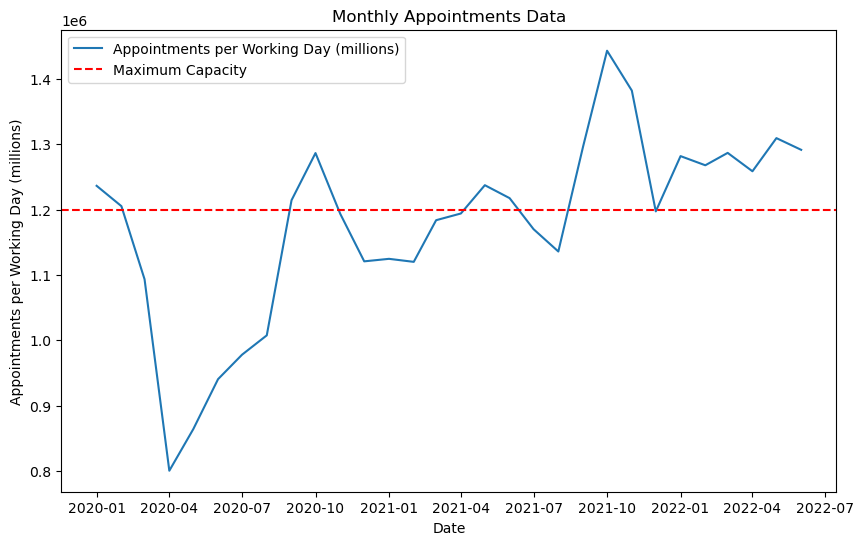

In [70]:
# Plot monthly appointments
plt.figure(figsize=(10, 6))
plt.plot(appt_wd, label='Appointments per Working Day (millions)')
plt.axhline(y = 1200000, color = 'r', linestyle = '--', label='Maximum Capacity')
plt.title('Monthly Appointments Data')
plt.xlabel('Date')
plt.ylabel('Appointments per Working Day (millions)')
plt.legend()
plt.savefig('appt_time_series.png')
plt.show()

**Appointments per working day exceed or meeting capacity from September 2021**

### Total Appointments Seasonal Decomposition

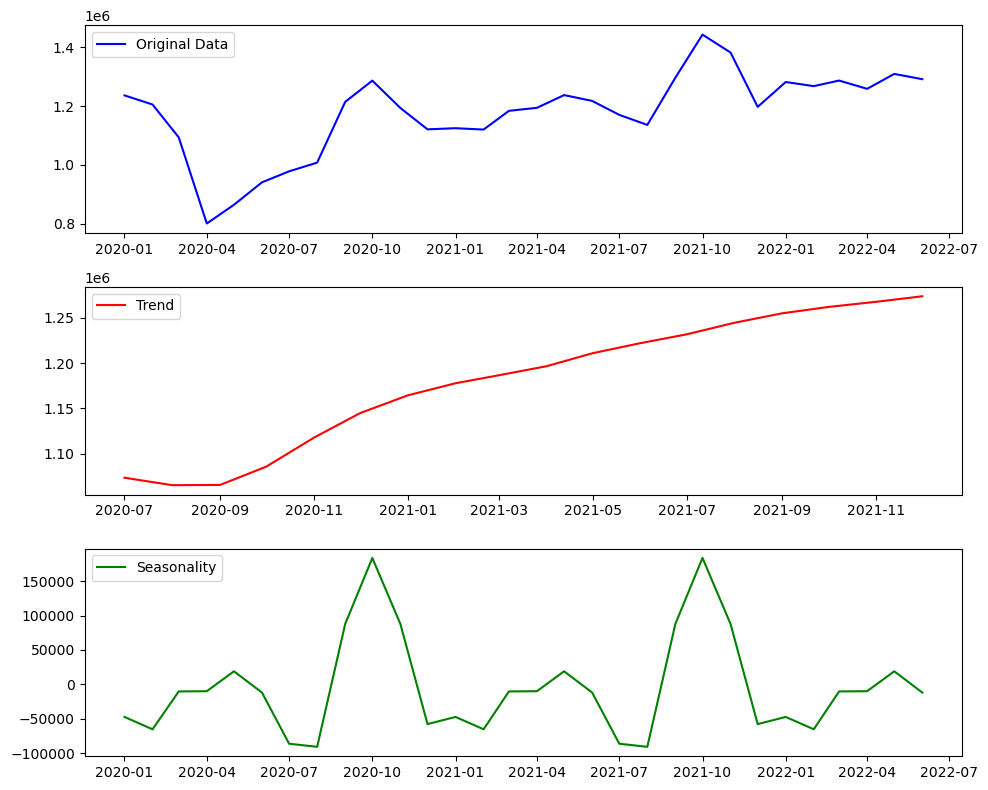

In [71]:
# Set decomposition model parameters
decomposition_appt = seasonal_decompose(appt_wd, model='additive', period=12)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# Plot Original Data
ax1.plot(appt_wd, label='Original Data', color='blue')
ax1.legend(loc='upper left')

# Plot Trend
ax2.plot(decomposition_appt.trend, label='Trend', color='red')
ax2.legend(loc='upper left')

# Plot Seasonality
ax3.plot(decomposition_appt.seasonal, label='Seasonality', color='green')
ax3.legend(loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.savefig('appt_trend.png')
plt.show()

**The seaonsal spikes are likely due to flu season. Source: [Spike in flu driving extremely busy winter for GPs as NHS faces 'national emergency'](https://www.gponline.com/spike-flu-driving-extremely-busy-winter-gps-nhs-faces-national-emergency/article/1901718)**

### Attended Appointments Time Series

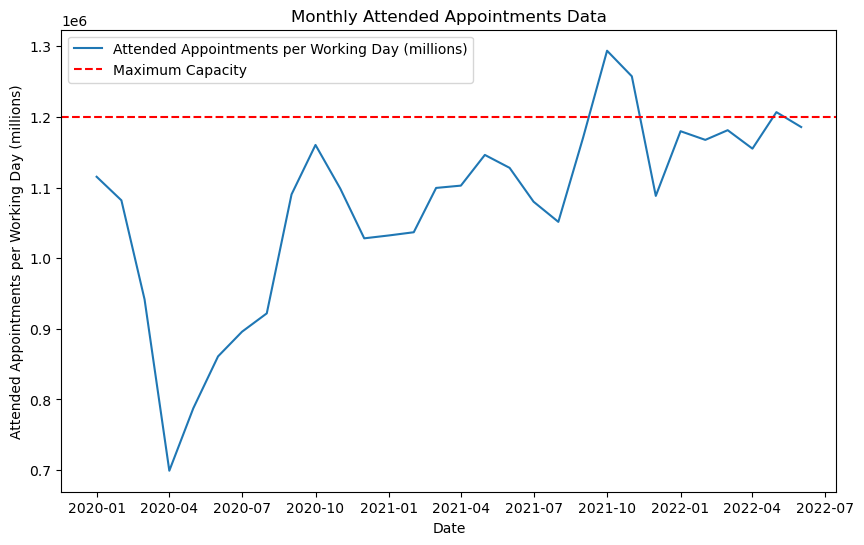

In [72]:
# Plot monthly attended appointments
plt.figure(figsize=(10, 6))
plt.plot(attd_wd, label='Attended Appointments per Working Day (millions)')
plt.axhline(y = 1200000, color = 'r', linestyle = '--', label='Maximum Capacity')
plt.title('Monthly Attended Appointments Data')
plt.xlabel('Date')
plt.ylabel('Attended Appointments per Working Day (millions)')
plt.legend()
plt.savefig('attd_time_series.png')
plt.show()

**Attended appointments for the months from December 2021 are below or near max capacity.**

### Attended Appointments Seasonal Decomposition

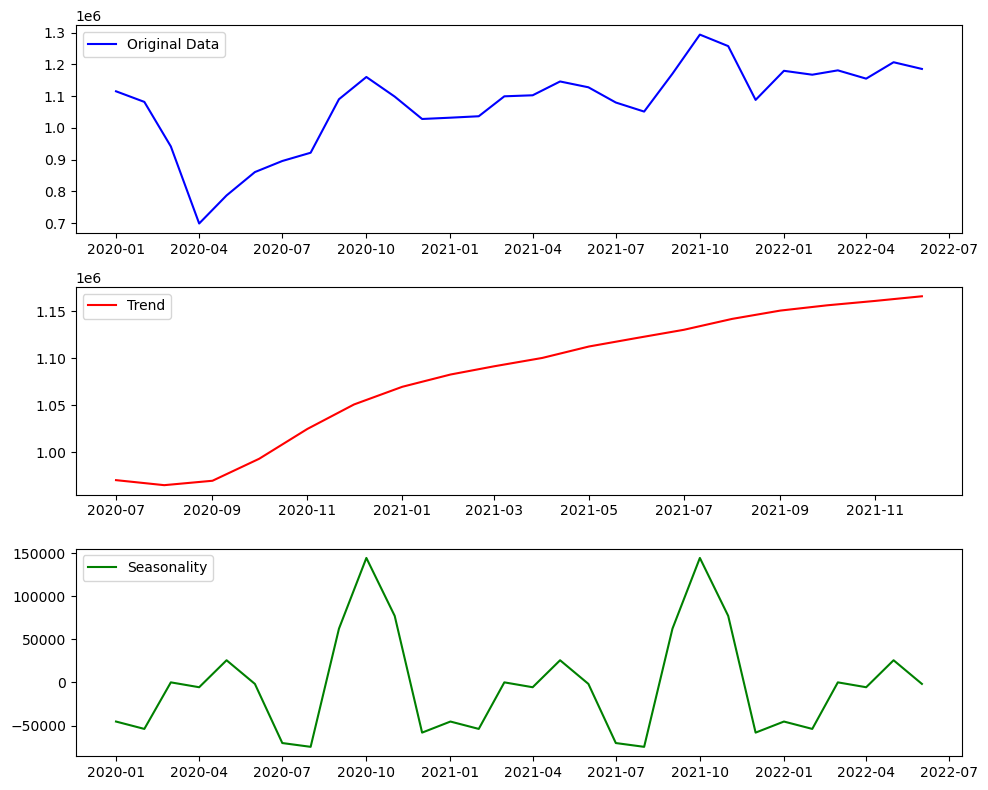

In [75]:
# Set decomposition model parameters
decomposition_attd = seasonal_decompose(attd_wd, model='additive', period=12)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# Plot Original Data
ax1.plot(attd_wd, label='Original Data', color='blue')
ax1.legend(loc='upper left')

# Plot Trend
ax2.plot(decomposition_attd.trend, label='Trend', color='red')
ax2.legend(loc='upper left')

# Plot Seasonality
ax3.plot(decomposition_attd.seasonal, label='Seasonality', color='green')
ax3.legend(loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.savefig('attd_trend.png')
plt.show()

### Total Registered Patients Time Series

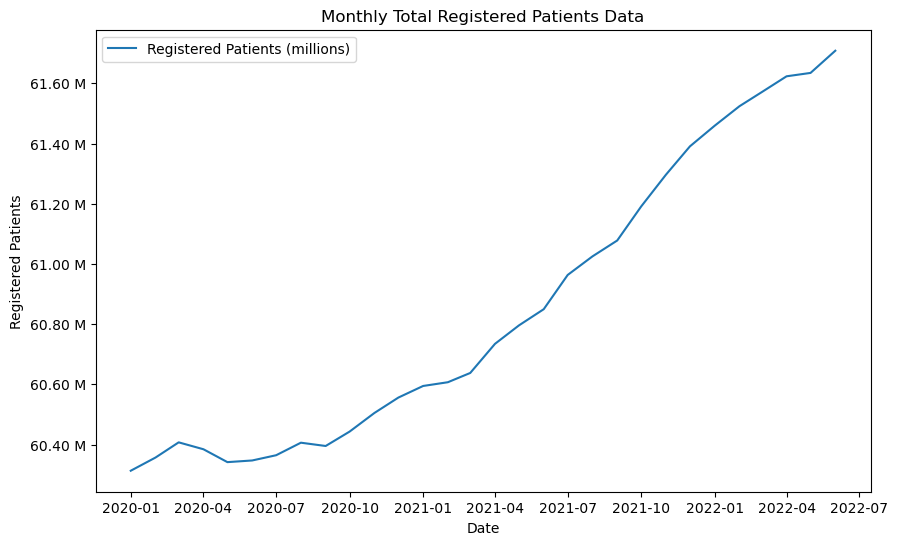

In [76]:
# Plot monthly registered patients
plt.figure(figsize=(10, 6))
plt.plot(pat_month, label='Registered Patients (millions)')
plt.title('Monthly Total Registered Patients Data')
plt.xlabel('Date')
plt.ylabel('Registered Patients')
plt.legend()
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter(unit='', places=2))
plt.savefig('totpat_time_series.png')
plt.show()

**There is a clear trend of registered patient numbers increasing over time.**

### Regional Deprivation and Attended Appointment Percentage Scatterplot

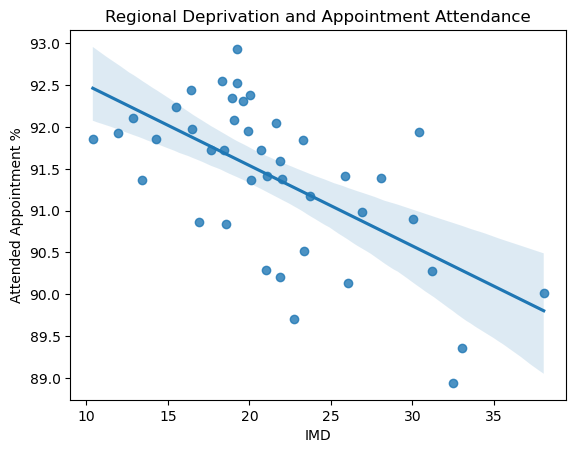

In [77]:
# Specify data for scatterplot
imd_scatter = sns.regplot(x='IMD', y='attendance_percentage', data=imd_attd)
# Specify axis labels
plt.xlabel('IMD')
plt.ylabel('Attended Appointment %')
plt.title('Regional Deprivation and Appointment Attendance')
# Save figure
fig = imd_scatter.get_figure()
fig.savefig('imd_scatter.png')

**There is a negative linear relationship between deprivation and appointment attendance. More deprived ICBs tend to have lower appointment attendance percentages.**

### Registered Patients and Appointment Count Scatterplot

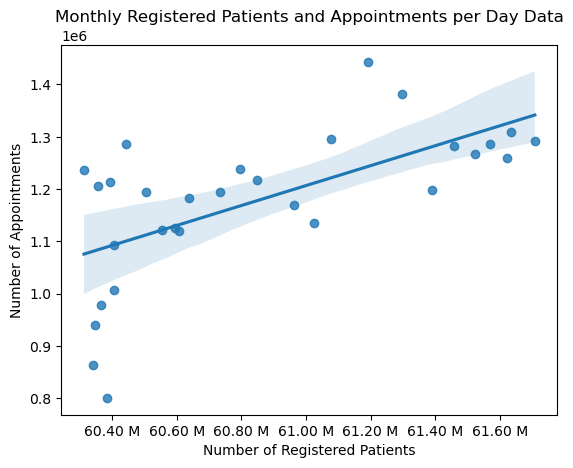

In [78]:
# Specify data for scatterplot
imd_scatter = sns.regplot(x='reg_patients', y='appt_per_day', data=pat_appt)
# Specify axis labels
plt.xlabel('Number of Registered Patients')
plt.gca().xaxis.set_major_formatter(ticker.EngFormatter(unit='', places=2))
plt.ylabel('Number of Appointments')
plt.title('Monthly Registered Patients and Appointments per Day Data')
# Save figure
fig = imd_scatter.get_figure()
fig.savefig('pat_appt_scatter.png')

**Months with more registered patients tend to have a higher number of appointments per day.**

### ICB GP:Patient Ratio and Attended Appointment Percentage Scatterplot

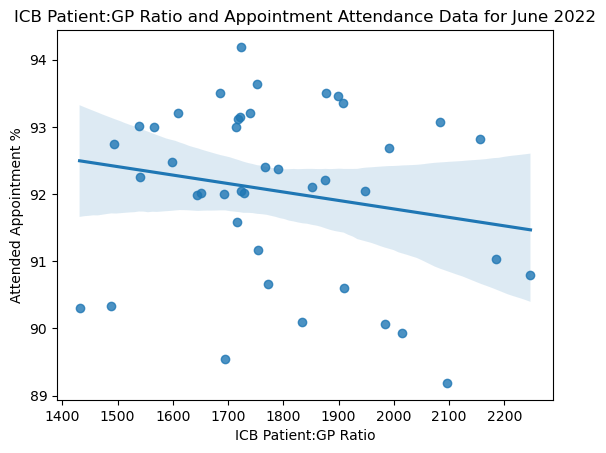

In [79]:
# Specify data for scatterplot
imd_scatter = sns.regplot(x='patients_per_gp', y='attendance_percentage', data=gp_pat_attd)
# Specify axis labels
plt.xlabel('ICB Patient:GP Ratio')
plt.ylabel('Attended Appointment %')
plt.title('ICB Patient:GP Ratio and Appointment Attendance Data for June 2022')
# Save figure
fig = imd_scatter.get_figure()
fig.savefig('patgp_scatter.png')

**There is a weak negative relationship between Patient:GP ratio and appointment attendance.**

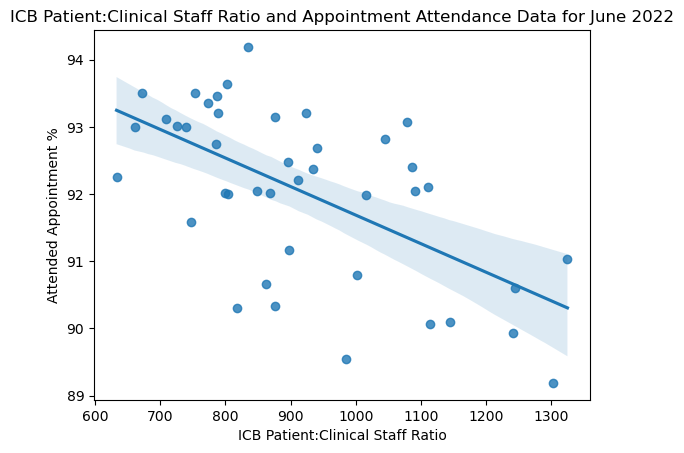

In [80]:
# Specify data for scatterplot
imd_scatter = sns.regplot(x='patients_per_clin', y='attendance_percentage', data=clin_pat_attd)
# Specify axis labels
plt.xlabel('ICB Patient:Clinical Staff Ratio')
plt.ylabel('Attended Appointment %')
plt.title('ICB Patient:Clinical Staff Ratio and Appointment Attendance Data for June 2022')
# Save figure
fig = imd_scatter.get_figure()
fig.savefig('patclin_scatter.png', bbox_inches='tight')

**There is a weak negative relationship between Patient:clinical staff ratio and appointment attendance.**

### Time between Booking and Appointment Duration and Appointment Attendance Bar Plot

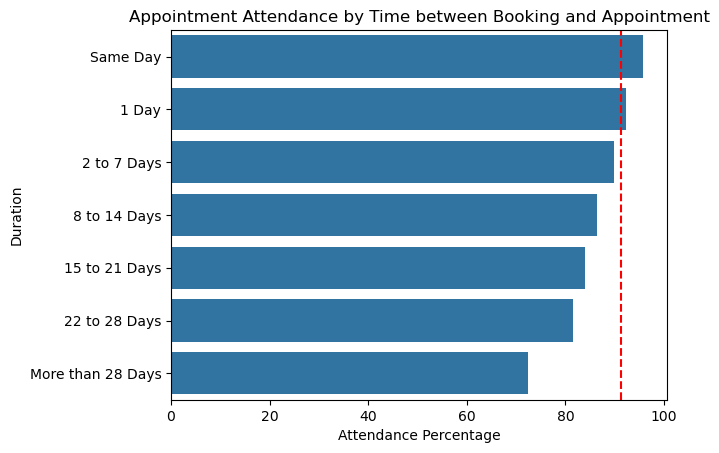

In [81]:
tbbaa_bar = sns.barplot(x=attd_tbbaa_filt.attendance_percentage, y=attd_tbbaa_filt.time_between_book_and_appointment, orient='h')
# Specify axis labels
plt.xlabel('Attendance Percentage')
plt.ylabel('Duration')
plt.title('Appointment Attendance by Time between Booking and Appointment')
plt.axvline(x = 91.24, color = 'r', linestyle = '--', label='Avg. Attendance')
# Save figure
fig = tbbaa_bar.get_figure()
fig.savefig('tbbaa_bar.png', bbox_inches='tight')

**Time between booking and appointment appears to have a significant effect of appointment attendance**

### Healthcare Professional Type and Appointment Attendance Bar Plot

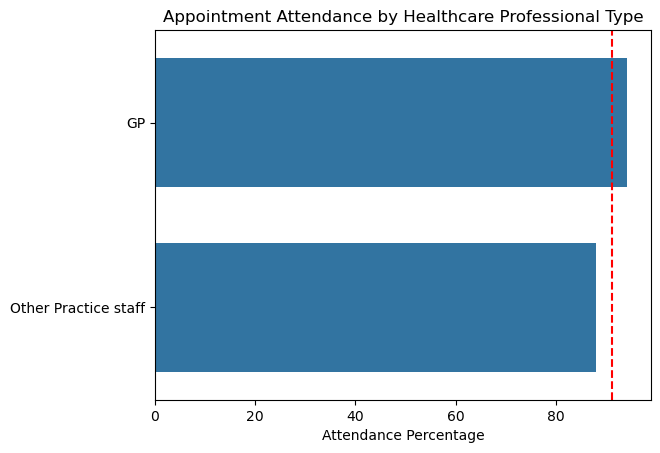

In [82]:
hcp_type_bar = sns.barplot(x=attd_hcp_type.attendance_percentage, y=attd_hcp_type.hcp_type, orient='h', width=0.7)
# Specify axis labels
plt.xlabel('Attendance Percentage')
plt.ylabel('')
plt.title('Appointment Attendance by Healthcare Professional Type')
plt.axvline(x = 91.24, color = 'r', linestyle = '--', label='Avg. Attendance')
# Save figure
fig = hcp_type_bar.get_figure()
fig.savefig('hcp_type_bar.png', bbox_inches='tight')

**Patients are probably more likely to attend appointments with GPs due to closer ties and a sense of accountability.**

### Appointment Mode and Appointment Attendance Bar Plot

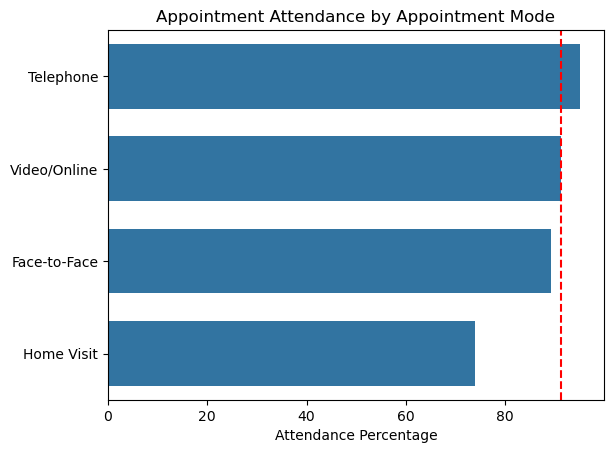

In [83]:
appt_mode_bar = sns.barplot(x=attd_appointment_mode.attendance_percentage, \
                            y=attd_appointment_mode.appointment_mode, orient='h', width=0.7, \
                            order=attd_appointment_mode.sort_values('attendance_percentage', ascending=False).appointment_mode)
# Specify axis labels
plt.xlabel('Attendance Percentage')
plt.ylabel('')
plt.title('Appointment Attendance by Appointment Mode')
plt.axvline(x = 91.24, color = 'r', linestyle = '--', label='Avg. Attendance')
# Save figure
fig = appt_mode_bar.get_figure()
fig.savefig('appt_mode_bar.png', bbox_inches='tight')

**Surprisingly home visits have the lowest attendance percentage: aren't these patients homebound?**

### Appointments per Day Bar Plot

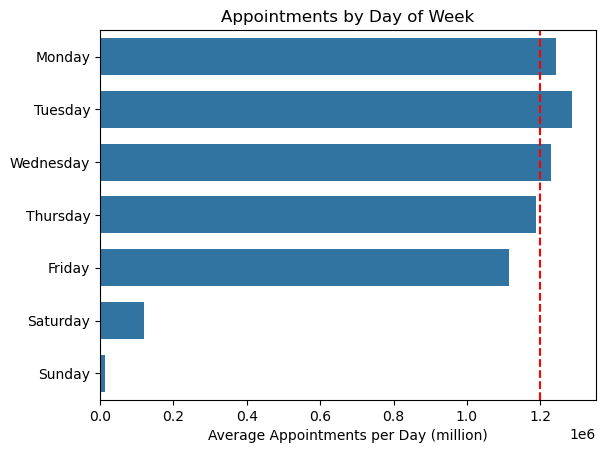

In [84]:
nc_day_of_week_mean_bar = sns.barplot(x=nc_day_of_week_mean.count_of_appointments, \
                            y=nc_day_of_week_mean.day_of_week, orient='h', width=0.7)
# Specify axis labels
plt.xlabel('Average Appointments per Day (million)')
plt.ylabel('')
plt.title('Appointments by Day of Week')
plt.axvline(x = 1200000, color = 'r', linestyle = '--', label='Avg. Attendance')
# Save figure
fig = nc_day_of_week_mean_bar.get_figure()
fig.savefig('nc_day_of_week_mean_bar', bbox_inches='tight')

**Most appointments are scheduled at the beginning of the week.**

### Appointment Count by Actual Duration Bar Plot

In [85]:
ad_gb

,actual_duration,count_of_appointments,percent
0,1-5 Minutes,28600865,22.397514
1,11-15 Minutes,25160882,19.703642
2,16-20 Minutes,16004247,12.533025
3,21-30 Minutes,15026365,11.767239
4,31-60 Minutes,9103432,7.128954
5,6-10 Minutes,33800815,26.469627


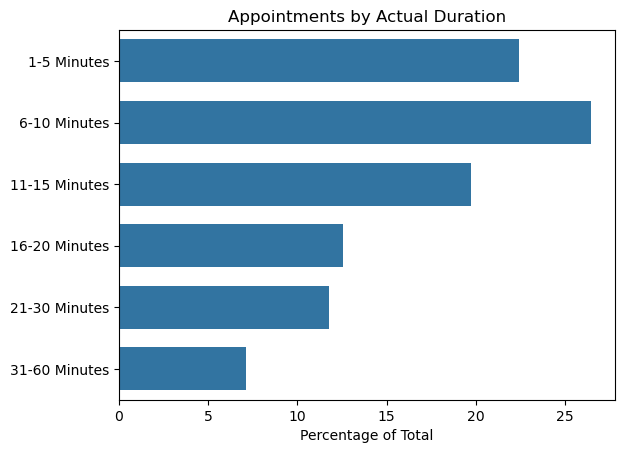

In [86]:
ad_gb_bar = sns.barplot(x=ad_gb.percent, \
                            y=ad_gb.actual_duration, orient='h', width=0.7)
# Specify axis labels
plt.xlabel('Percentage of Total')
plt.ylabel('')
plt.title('Appointments by Actual Duration')
# Save figure
fig = ad_gb_bar.get_figure()
fig.savefig('ad_gb_bar', bbox_inches='tight')

**The plurality of appointments are 10 minutes or less**

### Twitter Hashtag Frequency

In [87]:
# Create a new DataFrame containing only the text.
tweets_text = tweets.select_dtypes(include=object)

# View the DataFrame.
tweets_text

,tweet_full_text,tweet_entities,tweet_entities_hashtags,tweet_metadata,tweet_lang
0,"As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-being of our community as our next https://t.co/yw0cstfmSI #Healthcare","{'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url': 'bit.ly/3BiSKbs', 'indices': [229, 252]}]}",#Healthcare,"{'iso_language_code': 'en', 'result_type': 'recent'}",en
1,RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed. We're #hiring for…,"{'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer', 'id': 447676901, 'id_str': '447676901', 'indices': [3, 17]}], 'urls': []}","#PremiseHealth, #hiring","{'iso_language_code': 'en', 'result_type': 'recent'}",en
2,RT @OntarioGreens: $10 billion can go a long way to fixing our broken #Healthcare system.\n\nYet Doug Ford would rather spend it ALL on a hig…,"{'hashtags': [{'text': 'Healthcare', 'indices': [70, 81]}], 'symbols': [], 'user_mentions': [{'screen_name': 'OntarioGreens', 'name': 'Green Party of Ontario', 'id': 37115912, 'id_str': '37115912', 'indices': [3, 17]}], 'urls': []}",#Healthcare,"{'iso_language_code': 'en', 'result_type': 'recent'}",en
3,RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…,"{'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices': [3, 17]}], 'urls': []}",#NEW,"{'iso_language_code': 'en', 'result_type': 'recent'}",en
4,"ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #digitaltransformation #cybersecurity #accounting #finance #healthcare https://t.co/HC4tTrk8sW","{'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices': [229, 240]}, {'text': 'finance', 'indices': [241, 249]}, {'text': 'healthcare', 'indices': [250, 261]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/4nnK0FiVVL', 'expanded_url': 'https://bit.ly/3cOAsWh', 'display_url': 'bit.ly/3cOAsWh', 'indices': [55, 78]}, {'url': 'https://t.co/jIqn52lHD3', 'expanded_url': 'https://bit.ly/3cRX9c6', 'display_url': 'bit.ly/3cRX9c6', 'indices': [128, 151]}], 'media': [{'id': 1567582718711545857, 'id_str': '1567582718711545857', 'indices': [262, 285], 'media_url': 'http://pbs.twimg.com/media/FcEsLWDXwAEtf67.jpg', 'media_url_https': 'https://pbs.twimg.com/media/FcEsLWDXwAEtf67.jpg', 'url': 'https://t.co/HC4tTrk8sW', 'display_url': 'pic.twitter.com/HC4tTrk8sW', 'expanded_url': 'https://twitter.com/multiviewcorp/status/1567582720460570625/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 675, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 680, 'h': 383, 'resize': 'fit'}, 'large': {'w': 1440, 'h': 810, 'resize': 'fit'}}}]}","#blogs, #digitaltransformation, #cybersecurity, #accounting, #finance, #healthcare","{'iso_language_code': 'en', 'result_type': 'recent'}",en
...,...,...,...,...,...
1169,RT @PotomacPhotonic: Potomac #Innovation Report: #precisionFabrication techniques Optimize #Microfluidic Mixing of Viscous Fluids \n\n#manuf…,"{'hashtags': [{'text': 'Innovation', 'indices': [29, 40]}, {'text': 'precisionFabrication', 'indices': [50, 71]}, 

In [88]:
# Loop through the messages, and create a list of values containing the # symbol.
tags = []
for y in [x.split(' ') for x in tweets_text['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())

# Convert list to series
tags = pd.Series(tags)

# Display the first 30 records.
tags.head(30)

0                                    #healthcare
1                                 #premisehealth
2                                        #hiring
3                                    #healthcare
4                                        🚨#new:🚨
5                                look!\n\n#blogs
6                         #digitaltransformation
7                                 #cybersecurity
8                                    #accounting
9                                       #finance
10                                   #healthcare
11    https://t.co/jrgqeqdme4\n.\n#firstcoastcna
12                                      #cnaexam
13                           #cnaexampreparation
14                                 #jacksonville
15                                  #cnatraining
16                                        #nurse
17                                      #nursing
18                                    #nurselife
19                            #nursepractitioner
20                  

In [89]:
# Convert the series to a DataFrame in preparation for visualisation.
hashtag_count = tags.to_frame(name='word')
hashtag_count.head()

,word
0,#healthcare
1,#premisehealth
2,#hiring
3,#healthcare
4,🚨#new:🚨


In [90]:
# Group by hashtag and create count column 
hashtag_count = hashtag_count.groupby(['word']).word.agg('count').to_frame('count').reset_index()

# Sort descending
hashtag_count.sort_values(by='count', ascending=False).head(30)

,word,count
632,#healthcare,716
625,#health,80
919,#medicine,41
131,#ai,40
817,#job,38
894,#medical,35
1350,#strategy,30
1099,#pharmaceutical,28
461,#digitalhealth,25
880,#marketing,25


In [91]:
# Display records where the count is larger than 10 and exclude outliers
hcf = hashtag_count.loc[(hashtag_count['count'] > 10) & (hashtag_count['count'] < 80)].sort_values(by='count', ascending=False)
hcf

,word,count
919,#medicine,41
131,#ai,40
817,#job,38
894,#medical,35
1350,#strategy,30
1099,#pharmaceutical,28
1098,#pharma,25
880,#marketing,25
461,#digitalhealth,25
354,#competitiveintelligence,24


<Axes: xlabel='count', ylabel='word'>

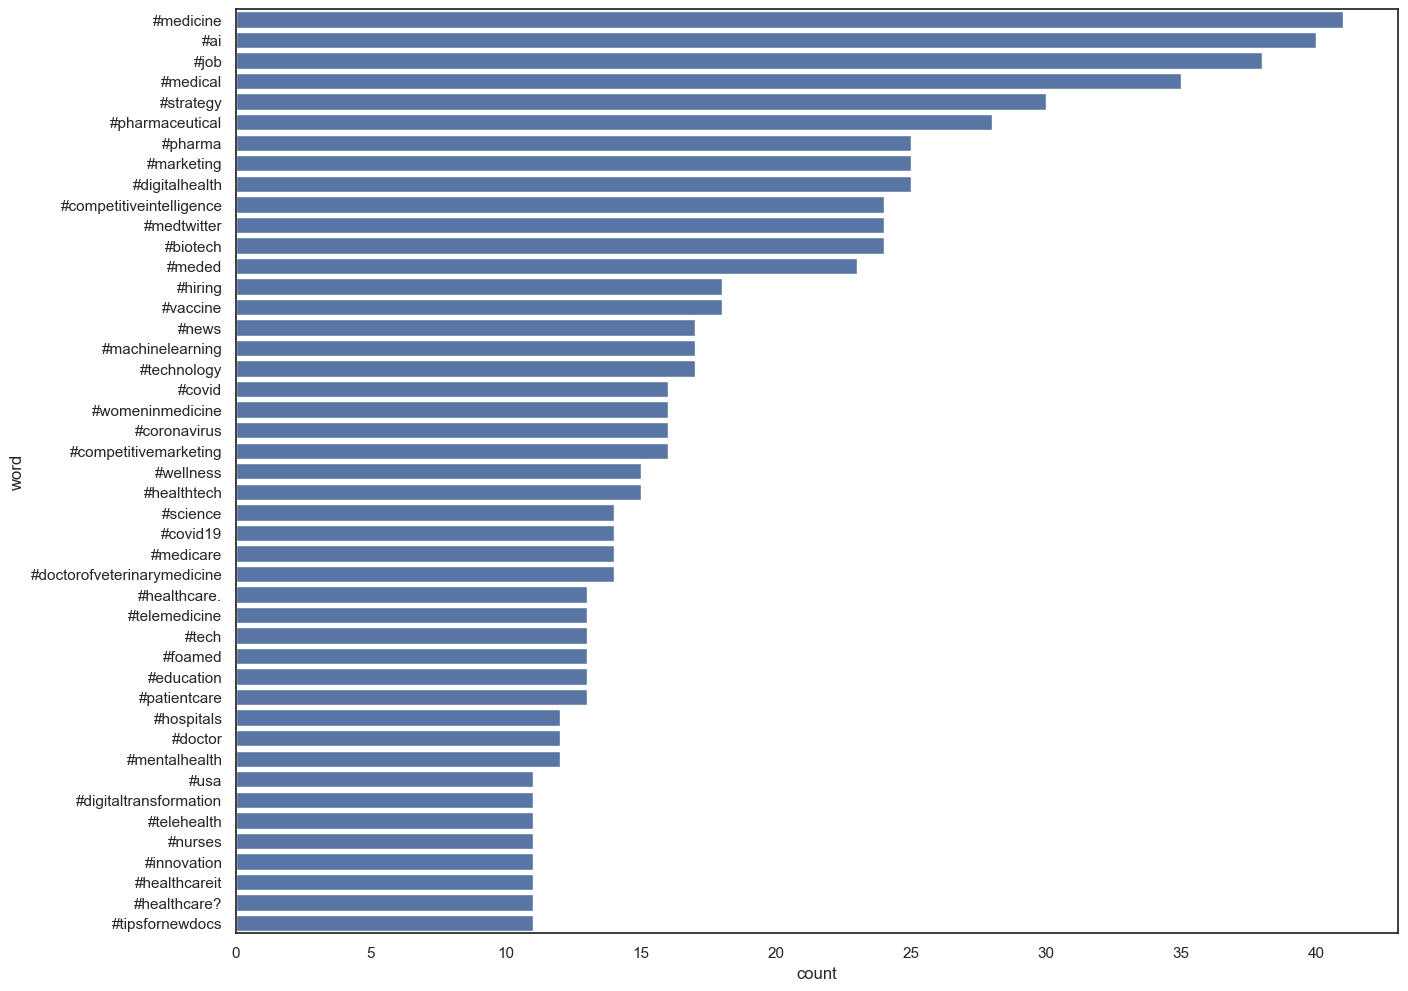

In [92]:
# remove \n\n in preparation for visualisation
hcf['word'] = hcf['word'].str.replace('drugs\n\n', '')

# Set the figure size.
sns.set(rc={'figure.figsize':(15, 12)})

# Set the plot style as white.
sns.set_style('white')

# Create a Seaborn barplot displaying records with a count larger than 10.
sns.barplot(x=hcf['count'], y=hcf['word'], orient='h')

**Based on my experience using Twitter/X, many tweets include trending but unrelated hashtags in an effort to increase engagement. These hashtags provide not appear to provide any insights regarding GP appointment and capacity in NHS England.**